In [8]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

#PDFs in BDT and sindec?
import os

# set env flags to catch BLAS used for scipy/numpy 
# to only use 1 cpu, n_cpus will be totally controlled by csky
os.environ['MKL_NUM_THREADS'] = "1"
os.environ['NUMEXPR_NUM_THREADS'] = "1"
os.environ['OMP_NUM_THREADS'] = "1"
os.environ['OPENBLAS_NUM_THREADS'] = "1"
os.environ['VECLIB_MAXIMUM_THREADS'] = "1"

import matplotlib as mpl
mpl.rcParams['figure.facecolor'] = 'w'
mpl.rcParams['savefig.facecolor'] = 'w'
import matplotlib.pyplot as plt
from matplotlib import colors, cm
import csky as cy
from csky import cext
import numpy as np
import pandas as pd
import astropy
#from icecube import astro
import histlite as hl
import healpy
import pickle
import socket
healpy.disable_warnings()
plt.rc('figure', facecolor = 'w')
plt.rc('figure', dpi=100)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Define Settings

In [3]:
selection_version = 'version-001-p00'

host_name = socket.gethostname()

if 'cobalt' in host_name:
    print('Working on Cobalts')
    data_prefix = '/data/user/ssclafani/data/cscd/final'
    ana_dir = '/data/user/ssclafani/data/analyses/'
    plot_dir = '/home/mhuennefeld/public_html/analyses/DNNCascade/plots/pdf_construction/check_ps_likelihood_assumptions'
    
elif 'phobos' in host_name:
    print('Working on Phobos')
    data_prefix = '/net/big-tank/POOL/users/mhuennefeld/analyses/DNNCascade/data/cscd/final'
    ana_dir = '/net/big-tank/POOL/users/mhuennefeld/analyses/DNNCascade/csky/analyses/'
    plot_dir = '/home/mhuennefeld/analyses/DNNCascade/plots/pdf_construction/check_ps_likelihood_assumptions'
    
else:
    raise ValueError('Unknown host:', host_name)

Working on Cobalts


In [4]:
for dir_path in [plot_dir]:
    if not os.path.exists(dir_path):
        print('Creating directory:', dir_path)
        os.makedirs(dir_path)

Creating directory: /home/mhuennefeld/public_html/analyses/DNNCascade/plots/pdf_construction/check_ps_likelihood_assumptions


## Load Data

In [5]:
repo = cy.selections.Repository()
specs = cy.selections.DNNCascadeDataSpecs.DNNC_10yr

In [6]:
class DNNCascade_10yr_mc_weights(cy.selections.DNNCascadeDataSpecs.DNNCascade_10yr):
    def dataset_modifications(self, ds):
        print('Adding weights to MC')
        path_sig_df = (
            '/data/ana/PointSource/DNNCascade/analysis/' + 
            self._path_sig.format(version=self._version).replace('dnn_cascades/', '').replace('.npy', '.hdf')
        )
        df = pd.read_hdf(path_sig_df, key='df')
        assert np.allclose(df['run'], ds.sig.run)
        assert np.allclose(df['energy'], ds.sig.energy)
        assert np.allclose(df['ow'], ds.sig.oneweight)
        for k in df.keys():
            if 'weight' in k or 'veto' in k:
                ds.sig[k] = df[k]

specs = [DNNCascade_10yr_mc_weights]

In [9]:
%%time

ana = cy.get_analysis(
    repo, selection_version, specs, 
    #gammas=np.r_[0.1:6.01:0.125],
)

Setting up Analysis for:
DNNCascade_10yr_mc_weights
Setting up DNNCascade_10yr_mc_weights...
Adding weights to MC
Energy PDF Ratio Model...
  * gamma = 4.0000 ...
Signal Acceptance Model...
  * gamma = 4.0000 ...
Done.
CPU times: user 15.7 s, sys: 6.83 s, total: 22.5 s
Wall time: 40 s


In [10]:
a = ana.anas[0]
a.sig

Events(398873 items | columns: azimuth, dec, energy, event, log10energy, mjd, nuveto_pf_dnn_cascade_selection_H3a_SIBYLL2_3c_conv, nuveto_pf_dnn_cascade_selection_H3a_SIBYLL2_3c_pr, nuveto_pf_dnn_cascade_selection_H3a_SIBYLL2_3c_total, ra, run, sigma, sindec, subevent, weights, weights_MCEq_H3a_sibyll2_3c_conv, weights_MCEq_H3a_sibyll2_3c_pr, weights_MCEq_H3a_sibyll2_3c_total, weights_aachen_flux, weights_aachen_flux_8yr, weights_cscd_hans, weights_cscd_icrc15, weights_global_fit, weights_hese4_bestfit, weights_hese4_fixed, weights_hese6, weights_hese_flux, weights_livetime, weights_mese_flux, weights_meta_info_n_events_per_run, weights_meta_info_n_files, xdec, xra, true_dec, true_energy, true_ra, oneweight)

In [11]:
a.bg_datata

Events(59610 items | columns: azimuth, dec, energy, event, log10energy, mjd, ra, run, sigma, sindec, subevent)

## Assumptions in PS Likelihood

The point source likelihood construction in csky (and other frameworks such as skylab) utilizes a few assumptions and simplifications. These are outlined in the following.

We use 4 observables ($\delta, \alpha, \sigma, E$) in the likelihood plus a number of conditionals that depend on the source hypothesis. In the case of our standard point source hypothesis, the conditionals are the spectral index of the source $\gamma$ and its position in the sky $\delta_s, \alpha_s$.
In principle we therefore have a 4-dimensional PDF (+ plus conditionals) as given by:

$P(\delta, \alpha, \sigma, E | \gamma, \delta_s, \alpha_s)$

In csky, the PDFs that are actually being used for signal and background are as follows:
* Signal: $S(\delta, \alpha | \sigma, \delta_s, \alpha_s) \cdot S(E | \gamma, \sin{\delta})$
* Background: $B(\alpha) \cdot B(\sin{\delta}) \cdot B(E | \sin{\delta})$

We can use the law of conditional probabilities $P(a, b) = P(a | b) \cdot P(b)$ to split up $P(\delta, \alpha, \sigma, E | \gamma, \delta_s, \alpha_s)$ into terms that resemble what's used in csky more closely. There are multiple ways of how this splitting can be performed. Here we will split up the PDF in a way that we can identify three main assumptions that go into the likelihood construction.

$S(\delta, \alpha, \sigma, E | \gamma, \delta_s, \alpha_s) = S(\delta, \alpha| \sigma, E , \gamma, \delta_s, \alpha_s) \cdot S(\sigma, E | \gamma, \delta_s, \alpha_s) = S(\delta, \alpha| \sigma, E , \gamma, \delta_s, \alpha_s) \cdot S(\sigma| E, \gamma, \delta_s, \alpha_s) \cdot S(E | \gamma, \delta_s, \alpha_s)$

And similarly for the background PDFs which do not depend on the source hypothesis:

$B(\delta, \alpha, \sigma, E) = B(\alpha) \cdot B(\delta, \sigma, E | \alpha) = B(\alpha) \cdot B(\delta | \alpha) \cdot B(\sigma, E | \alpha, \delta)  = B(\alpha) \cdot B(\delta | \alpha) \cdot B(\sigma | E, \alpha, \delta) \cdot B(E | \alpha, \delta)$

We can further drop the $\alpha$ conditional from the sigma and energy term, since these PDFs should not depend on this (note that for something like the kra-gamma templates this does not necessarily apply due to the differing location-dependent spectrum), and introduce a change of variable from $\delta$ to $\sin{\delta}$ to arrive at:


$S(\delta, \alpha, \sigma, E | \gamma, \delta_s, \alpha_s) = S(\delta, \alpha| \sigma, E, \gamma, \delta_s, \alpha_s) \cdot S(\sigma | E, \gamma, \delta_s) \cdot S(E | \gamma, \sin{\delta_s})$

$B(\delta, \alpha, \sigma, E) = B(\alpha) \cdot B(\sin{\delta}) \cdot B(\sigma | E, \delta) \cdot B(E | \sin{\delta})$

When comparing this to the PDFs used in csky, we can see that the $\sigma$ term is ommitted and that some of the conditionals in the energy PDFs changed. These changes are valid if a set of assumptions is true:

1. $S(\delta, \alpha| \sigma, E, \gamma, \delta_s, \alpha_s) \approx S(\delta, \alpha| \sigma, \delta_s, \alpha_s)$. This is valid, if $\sigma$ "absorbs" the energy and spectral index conditionals, or in other words, if the coverage of the PSF (von-Mises/Fisher distribution) holds independent of the event energy or spectral index.

2. $\frac{ S(\sigma | E, \gamma, \delta_s)}{B(\sigma | E, \delta)} \approx 1$. If this ratio is approximately one, then we can ommit the sigma terms. Usually the angular uncertainty $\sigma$ is mostly a function of energy. If the dependence on $\delta, \delta_s, \gamma$ is weak, this approximation holds.

3. $S(E | \gamma, \sin{\delta_s}) \approx S(E | \gamma, \sin{\delta})$. For simplicity, we typically build the signal energy PDF conditional on the reconstructed event declination $\delta$ rather than the assumed source declintation $\delta_s$. For event samples with small angular errors such as track, this is mostly a good assumption. If the event is well reconstructed, $\delta_s \approx \delta$ is valid. Events that are further away from the source for which this approximation does not hold, are heavily down-weighted by the spatial signal term. These events for which this assumption does not hold therefore do not contribute much to the overall likelihood. Therefore, this is usually a good enough approximation, but it may cause issues for event samples with large angular uncertainties such as cascades.


In the following, we will investigate if these assumptions hold for the DNNCascade event selection.

## Assumption 1: Coverage holds

1. $S(\delta, \alpha| \sigma, E, \gamma, \delta_s, \alpha_s) \approx S(\delta, \alpha| \sigma, \delta_s, \alpha_s)$. This is valid, if $\sigma$ "absorbs" the energy and spectral index conditionals, or in other words, if the coverage of the PSF (von-Mises/Fisher distribution) holds independent of the event energy or spectral index.

In [14]:
from dnn_cascade_selection.utils.notebook import coordinates
import ps_pdf

No module named 'icecube'
Continuing without support for `dir_to_equa`!


In [18]:
# compute opening angle
a.sig.dpsi = coordinates.get_ra_dec_angle(
    ra1=a.sig.true_ra, dec1=a.sig.true_dec, ra2=a.sig.ra, dec2=a.sig.dec
)
a.sig.dpsi_deg

array([11.428184, 33.805557, 32.31216 , ...,  9.071554,  6.278353,
       38.20021 ], dtype=float32)

#### Helper Functions 

In [21]:
from itertools import cycle

def get_ls_cycler():
    return cycle(['-', '--', ':', '-.'])

def get_color_cycler():
    return cycle(['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf'])

def reweight(ow, energy, gamma, norm=1.0e-18, 
             e_pivot=1e5, energy_cutoff=None):
    """Reweight events according to power_law
    """
    n_types = 2.  # Dividing by n_types gives flux per flavor and per type
    weight = ow * norm * np.power(energy/e_pivot, -gamma) / n_types
    
    if energy_cutoff is not None:
        weight *= np.exp(-energy / energy_cutoff)
    return weight



#### Sigma-dependent $\Delta\Psi$ Distribution

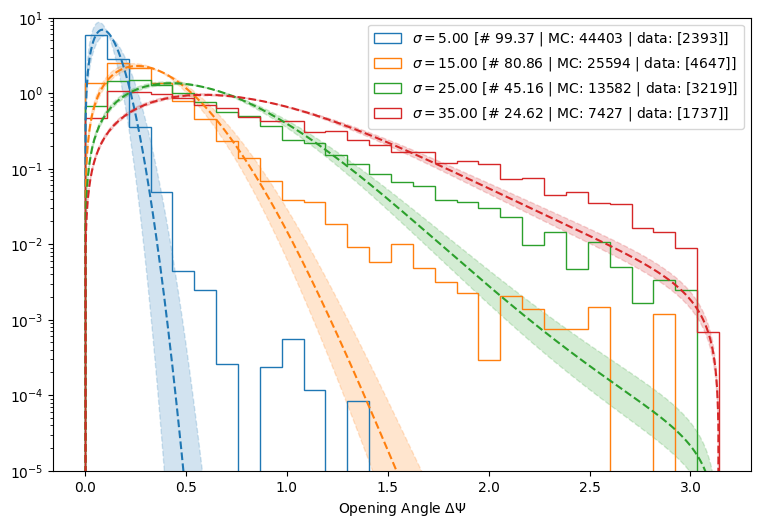

In [28]:
gamma = 2.5

fig, ax = plt.subplots(figsize=(9, 6))
bins = np.linspace(0, np.pi, 30)
bin_mids = bins[:-1] + 0.5*np.diff(bins)
bin_mids = np.linspace(0, np.pi, 1000)

weights = reweight(
    ow=a.sig.oneweight,
    energy=a.sig.true_energy,
    gamma=gamma,
) * 365. * 24. * 3600. * 10

sigma_width_deg = 1.0
color_cycler = get_color_cycler()
for sigma_deg in np.linspace(5., 35, 4):
    mask = np.logical_and(
        a.sig.sigma > np.deg2rad(sigma_deg - sigma_width_deg),
        a.sig.sigma < np.deg2rad(sigma_deg + sigma_width_deg),
    )
    mask_bkg = np.logical_and(
        a.bg_data.sigma > np.deg2rad(sigma_deg - sigma_width_deg),
        a.bg_data.sigma < np.deg2rad(sigma_deg + sigma_width_deg),
    )
    color = next(color_cycler)
    ax.hist(
        a.sig.dpsi[mask],
        weights=weights[mask],
        label='$\sigma={:3.2f}$ [# {:3.2f} | MC: {} | data: [{}]]'.format(
            sigma_deg, np.sum(weights[mask]), np.sum(mask), np.sum(mask_bkg)),
        histtype='step',
        bins=bins,
        density=True,
        color=color,
    )
    von_mises_values = ps_pdf.von_mises_in_dPsi_pdf(
        bin_mids, sigma=np.deg2rad(sigma_deg))
    ax.plot(
        bin_mids,
        von_mises_values,
        color=color,
        ls='--',
    )
    ax.fill_between(
        bin_mids,
        ps_pdf.von_mises_in_dPsi_pdf(
            bin_mids, sigma=np.deg2rad(sigma_deg - sigma_width_deg)),
        ps_pdf.von_mises_in_dPsi_pdf(
            bin_mids, sigma=np.deg2rad(sigma_deg + sigma_width_deg)),
        color=color,
        alpha=0.2,
        ls='--',
    )

ax.set_xlabel('Opening Angle $\Delta\Psi$')
ax.set_yscale('log')
#ax.set_xscale('log')
ax.set_ylim(1e-5, 1e1)
ax.legend()
fig.savefig('{}/psf_hist.png'.format(plot_dir))

#### Settings

In [31]:
quantiles = np.linspace(0.01, 1, 20)

#### Gamma dependent coverage

  0%|          | 0/7 [00:00<?, ?it/s]

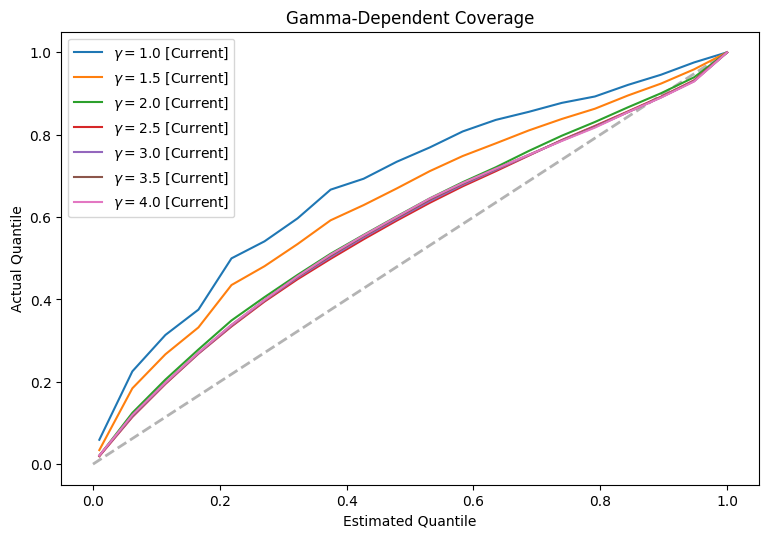

In [61]:
from tqdm.notebook import tqdm
every_nth = 11

fig, ax = plt.subplots(figsize=(9, 6))
ax.plot((0., 1.), (0., 1.), ls='--', lw=2., color='0.7')

#for gamma in [2.5]:
#for gamma in [2.0, 2.5, 3.0]:
#for gamma in [1.0, 4.0]:
for gamma in tqdm(np.linspace(1, 4, 7)):
    # -------
    # Current
    # -------
    weights = reweight(
        ow=a.sig.oneweight[::every_nth],
        energy=a.sig.true_energy[::every_nth],
        gamma=gamma,
    )
    _, cov_values = ps_pdf.compute_von_mises_coverage(
        dPsi=a.sig.dpsi[::every_nth],
        sigma=a.sig.sigma[::every_nth],
        weights=weights,
        quantiles=quantiles,
    )
    ax.plot(
        quantiles, cov_values, 
        ls='-',
        label='$\gamma={:.1f}$ [Current]'.format(gamma)
    )
    

ax.set_title('Gamma-Dependent Coverage')
ax.set_xlabel('Estimated Quantile')
ax.set_ylabel('Actual Quantile')
ax.legend()
fig.savefig('{}/coverage_gamma.png'.format(plot_dir))


#### Energy dependent coverage

  0%|          | 0/6 [00:00<?, ?it/s]

Clipping 1 events to max.
Clipping 1 events to max.
Clipping 1 events to max.
Clipping 1 events to max.
Clipping 1 events to max.
Clipping 1 events to max.


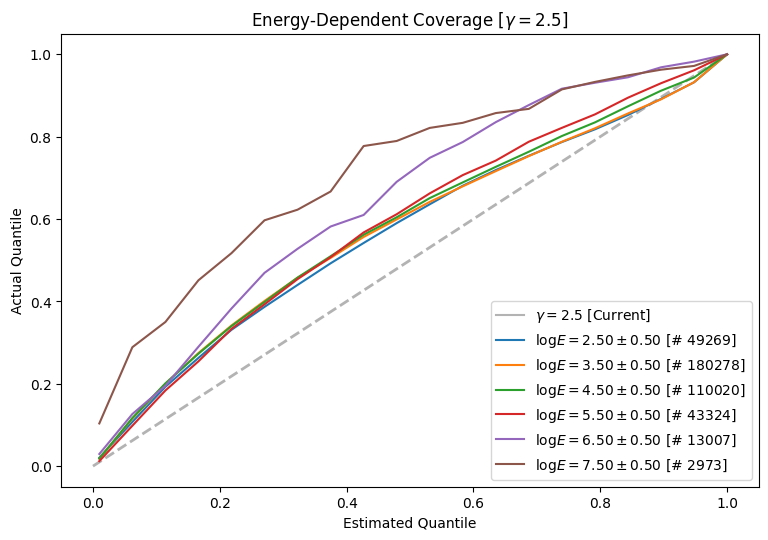

In [56]:
from tqdm.notebook import tqdm

every_nth = 11

fig, ax = plt.subplots(figsize=(9, 6))
ax.plot((0., 1.), (0., 1.), ls='--', lw=2., color='0.7')

gamma = 2.5
e_width = 0.5
created_labels = False
color_cycler = get_color_cycler()
for e_mid in tqdm(np.linspace(2.5, 7.5, 6)):
    color = next(color_cycler)
    ls_cycler = get_ls_cycler()

    ls = next(ls_cycler)

    mask = np.logical_and(
        a.sig.log10energy > e_mid - e_width,
        a.sig.log10energy < e_mid + e_width,
    )

    weights = reweight(
        ow=a.sig.oneweight[mask][::every_nth],
        energy=a.sig.true_energy[mask][::every_nth],
        gamma=gamma,
    )
    _, cov_values = ps_pdf.compute_von_mises_coverage(
        dPsi=a.sig.dpsi[mask][::every_nth],
        sigma=a.sig.sigma[mask][::every_nth],
        weights=weights,
        quantiles=quantiles,
    )
    ax.plot(quantiles, cov_values, ls=ls, color=color)
    
    if not created_labels:
        ax.plot(np.inf, np.inf, ls=ls, color='0.7', 
            label='$\gamma={:.1f}$ [Current]'.format(gamma))
            
    ax.plot(np.inf, np.inf, 
            label='$\log E={:3.2f} \pm {:3.2f}$ [# {}]'.format(
                e_mid, e_width, np.sum(mask)))
    created_labels = True

ax.set_xlabel('Estimated Quantile')
ax.set_ylabel('Actual Quantile')
ax.set_title('Energy-Dependent Coverage [$\gamma={:.1f}$]'.format(gamma))
ax.legend()
fig.savefig('{}/coverage_energy.png'.format(plot_dir))


#### Sigma-Dependent Coverage

  0%|          | 0/15 [00:00<?, ?it/s]

Clipping 1 events to max.
Clipping 1 events to max.
Clipping 1 events to max.
Clipping 1 events to max.
Clipping 1 events to max.
Clipping 1 events to max.
Clipping 1 events to max.
Clipping 1 events to max.
Clipping 1 events to max.
Clipping 1 events to max.
Clipping 1 events to max.
Clipping 1 events to max.


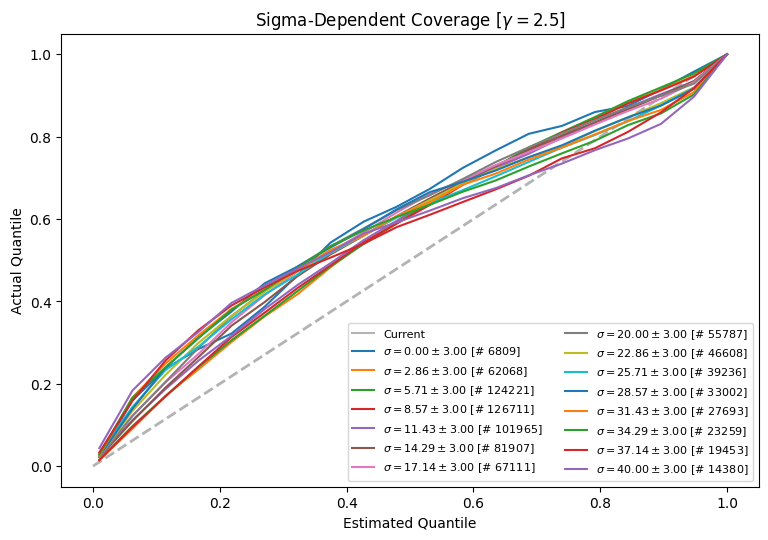

In [58]:
every_nth = 11

fig, ax = plt.subplots(figsize=(9, 6))
ax.plot((0., 1.), (0., 1.), ls='--', lw=2., color='0.7')

gamma = 2.5
sigma_width = np.deg2rad(3)
created_labels = False
color_cycler = get_color_cycler()
for sigma_mid in tqdm(np.deg2rad(np.linspace(0., 40, 15))):
    color = next(color_cycler)
    ls_cycler = get_ls_cycler()
    
    ls = next(ls_cycler)

    mask = np.logical_and(
        a.sig.sigma > sigma_mid - sigma_width,
        a.sig.sigma < sigma_mid + sigma_width,
    )
    if np.sum(mask) < 10:
        continue

    weights = reweight(
        ow=a.sig.oneweight[mask][::every_nth],
        energy=a.sig.true_energy[mask][::every_nth],
        gamma=gamma,
    )
    _, cov_values = ps_pdf.compute_von_mises_coverage(
        dPsi=a.sig.dpsi[mask][::every_nth],
        sigma=a.sig.sigma[mask][::every_nth],
        weights=weights,
        quantiles=quantiles,
    )
    ax.plot(quantiles, cov_values, ls=ls, color=color)
    if not created_labels:
        ax.plot(np.inf, np.inf, ls=ls, color='0.7', label='Current')
        
    ax.plot(np.inf, np.inf, 
            label='$\sigma={:3.2f} \pm {:3.2f}$ [# {}]'.format(
                np.rad2deg(sigma_mid), np.rad2deg(sigma_width), np.sum(mask)))
    created_labels = True

ax.set_xlabel('Estimated Quantile')
ax.set_ylabel('Actual Quantile')
ax.set_title('Sigma-Dependent Coverage [$\gamma={:.1f}$]'.format(gamma))
ax.legend(ncol=2, fontsize=8)
fig.savefig('{}/coverage_sigma.png'.format(plot_dir))


#### Declination dependent coverage

  0%|          | 0/18 [00:00<?, ?it/s]

Clipping 1 events to max.
Clipping 1 events to max.
Clipping 1 events to max.
Clipping 1 events to max.
Clipping 1 events to max.
Clipping 1 events to max.
Clipping 1 events to max.
Clipping 1 events to max.
Clipping 1 events to max.
Clipping 1 events to max.
Clipping 1 events to max.
Clipping 1 events to max.
Clipping 1 events to max.
Clipping 1 events to max.
Clipping 1 events to max.
Clipping 1 events to max.
Clipping 1 events to max.
Clipping 1 events to max.


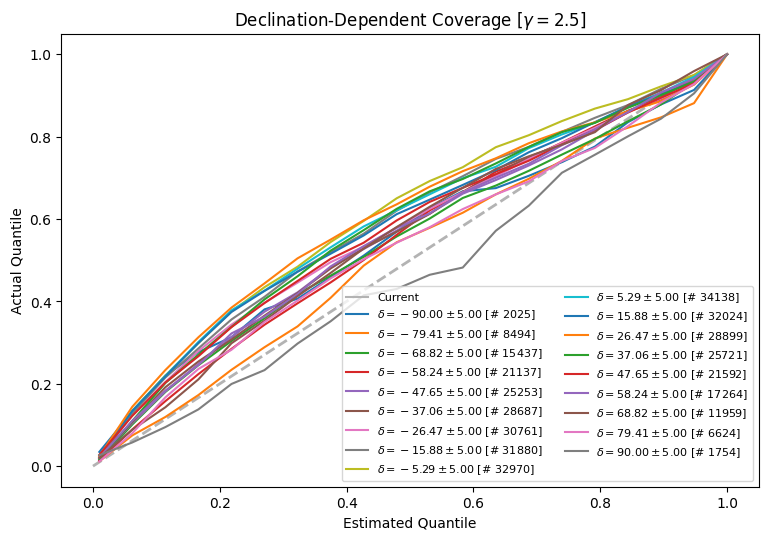

In [59]:
every_nth = 11

fig, ax = plt.subplots(figsize=(9, 6))
ax.plot((0., 1.), (0., 1.), ls='--', lw=2., color='0.7')

gamma = 2.5
dec_width = np.deg2rad(5)
created_labels = False
color_cycler = get_color_cycler()
for dec_mid in tqdm(np.deg2rad(np.linspace(-90, 90, 18))):
    color = next(color_cycler)
    ls_cycler = get_ls_cycler()
    
    ls = next(ls_cycler)

    mask = np.logical_and(
        a.sig.dec > dec_mid - dec_width,
        a.sig.dec < dec_mid + dec_width,
    )
    if np.sum(mask) < 10:
        continue

    weights = reweight(
        ow=a.sig.oneweight[mask][::every_nth],
        energy=a.sig.true_energy[mask][::every_nth],
        gamma=gamma,
    )
    _, cov_values = ps_pdf.compute_von_mises_coverage(
        dPsi=a.sig.dpsi[mask][::every_nth],
        sigma=a.sig.sigma[mask][::every_nth],
        weights=weights,
        quantiles=quantiles,
    )
    ax.plot(quantiles, cov_values, ls=ls, color=color)
    if not created_labels:
        ax.plot(np.inf, np.inf, ls=ls, color='0.7', label='Current')
        
    ax.plot(np.inf, np.inf, 
            label='$\delta={:3.2f} \pm {:3.2f}$ [# {}]'.format(
                np.rad2deg(dec_mid), np.rad2deg(dec_width), np.sum(mask)))
    created_labels = True

ax.set_xlabel('Estimated Quantile')
ax.set_ylabel('Actual Quantile')
ax.set_title('Declination-Dependent Coverage [$\gamma={:.1f}$]'.format(gamma))
ax.legend(ncol=2, fontsize=8)
fig.savefig('{}/coverage_dec.png'.format(plot_dir))


#### TrueDec-Dependent Coverage

  0%|          | 0/18 [00:00<?, ?it/s]

Clipping 1 events to max.
Clipping 1 events to max.
Clipping 1 events to max.
Clipping 1 events to max.
Clipping 1 events to max.
Clipping 1 events to max.
Clipping 1 events to max.
Clipping 1 events to max.
Clipping 1 events to max.
Clipping 1 events to max.
Clipping 1 events to max.
Clipping 1 events to max.
Clipping 1 events to max.


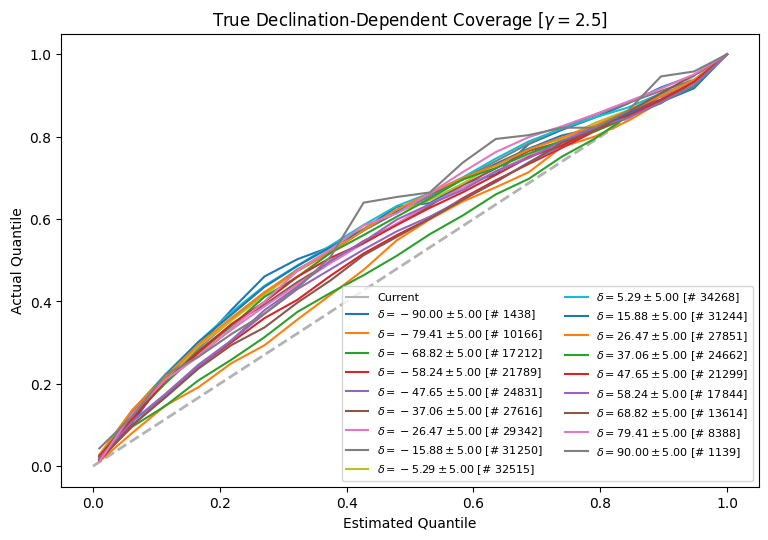

In [60]:
every_nth = 11

fig, ax = plt.subplots(figsize=(9, 6))
ax.plot((0., 1.), (0., 1.), ls='--', lw=2., color='0.7')

gamma = 2.5
dec_width = np.deg2rad(5)
created_labels = False
color_cycler = get_color_cycler()
for dec_mid in tqdm(np.deg2rad(np.linspace(-90, 90, 18))):
    color = next(color_cycler)
    ls_cycler = get_ls_cycler()
    
    ls = next(ls_cycler)

    mask = np.logical_and(
        a.sig.true_dec > dec_mid - dec_width,
        a.sig.true_dec < dec_mid + dec_width,
    )
    if np.sum(mask) < 10:
        continue

    weights = reweight(
        ow=a.sig.oneweight[mask][::every_nth],
        energy=a.sig.true_energy[mask][::every_nth],
        gamma=gamma,
    )
    _, cov_values = ps_pdf.compute_von_mises_coverage(
        dPsi=a.sig.dpsi[mask][::every_nth],
        sigma=a.sig.sigma[mask][::every_nth],
        weights=weights,
        quantiles=quantiles,
    )
    ax.plot(quantiles, cov_values, ls=ls, color=color)
    if not created_labels:
        ax.plot(np.inf, np.inf, ls=ls, color='0.7', label='Current')
        
    ax.plot(np.inf, np.inf, 
            label='$\delta={:3.2f} \pm {:3.2f}$ [# {}]'.format(
                np.rad2deg(dec_mid), np.rad2deg(dec_width), np.sum(mask)))
    created_labels = True

ax.set_xlabel('Estimated Quantile')
ax.set_ylabel('Actual Quantile')
ax.set_title('True Declination-Dependent Coverage [$\gamma={:.1f}$]'.format(gamma))
ax.legend(ncol=2, fontsize=8)
fig.savefig('{}/coverage_true_dec.png'.format(plot_dir))


## Assumption 2: sigma term can be ommitted

2. $\frac{ S(\sigma | E, \gamma, \delta_s)}{B(\sigma | E, \delta)} \approx 1$. If this ratio is approximately one, then we can ommit the sigma terms. Usually the angular uncertainty $\sigma$ is mostly a function of energy. If the dependence on $\delta, \delta_s, \gamma$ is weak, this approximation holds.

In [125]:
def get_ratio(
            e_mid, gamma, dec_s_mid, dec_mid, 
            dec_width=np.deg2rad(15), dec_width_s=np.deg2rad(15), e_width=0.3, 
            bins=np.linspace(0, np.deg2rad(45), 30),
        ):
    
    mask_1 = np.logical_and(
        a.sig.true_dec > dec_s_mid - dec_width_s,
        a.sig.true_dec < dec_s_mid + dec_width_s,
    )
    mask_2 = np.logical_and(
        a.sig.log10energy > e_mid - e_width,
        a.sig.log10energy < e_mid + e_width,
    )
    mask_bkg_1 = np.logical_and(
        a.bg_data.dec > dec_s_mid - dec_width,
        a.bg_data.dec < dec_s_mid + dec_width,
    )
    mask_bkg_2 = np.logical_and(
        a.bg_data.log10energy > e_mid - e_width,
        a.bg_data.log10energy < e_mid + e_width,
    )
    
    mask = np.logical_and(mask_1, mask_2)
    mask_bkg = np.logical_and(mask_bkg_1, mask_bkg_2)

    weights = reweight(
        ow=a.sig.oneweight[mask],
        energy=a.sig.true_energy[mask],
        gamma=gamma,
    )
    
    n_bkg = np.sum(mask_bkg)
    #print('Number of background events: {}'.format(np.sum(mask_bkg)))
    h, bin_edges = np.histogram(a.sig.sigma[mask], bins=bins, weights=weights, density=True)
    h_bkg, bin_edges = np.histogram(a.bg_data.sigma[mask_bkg], bins=bins, density=True)
    
    mask_valid = np.logical_and(h_bkg > 0, h > 0)
    h[~mask_valid] = 1.
    h_bkg[~mask_valid] = 1.
    ratio = h / h_bkg
    ratio[~mask_valid] = float('NaN')
    
    return h, h_bkg, h_bkg/h, n_bkg

h, h_bkg, s_over_b, n_bkg = get_ratio(e_mid=2.5, gamma=3., dec_s_mid=np.deg2rad(20), dec_mid=np.deg2rad(30))
#s_over_b

#### Check Gamma Dependence

  0%|          | 0/7 [00:00<?, ?it/s]

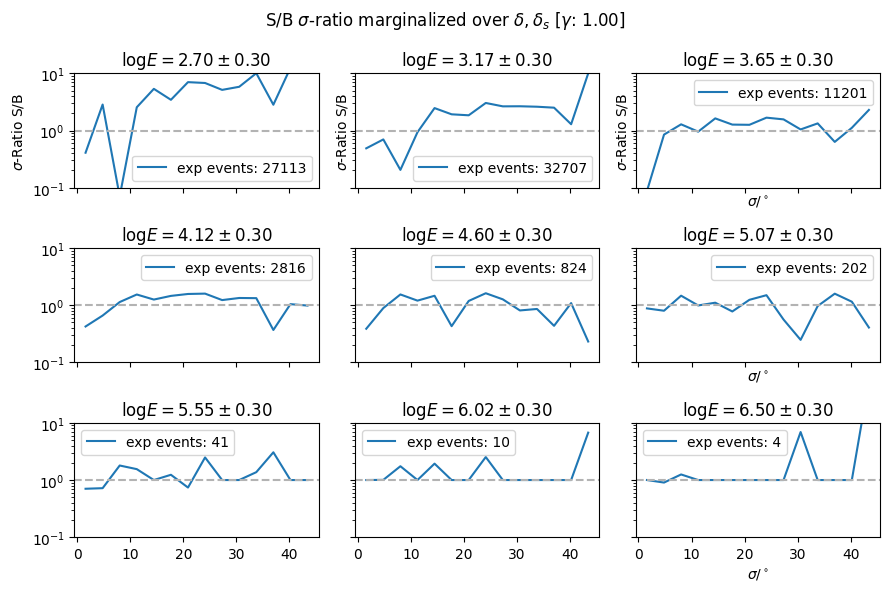

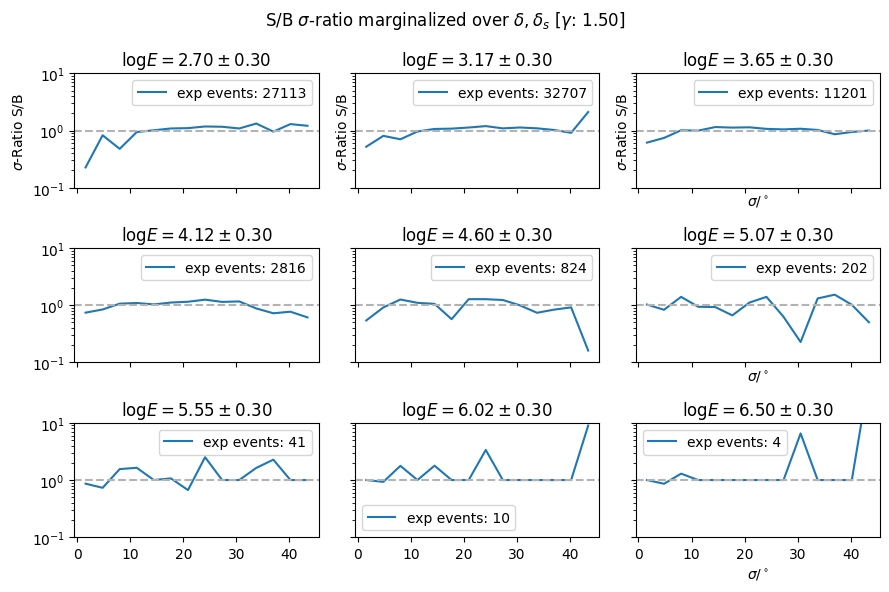

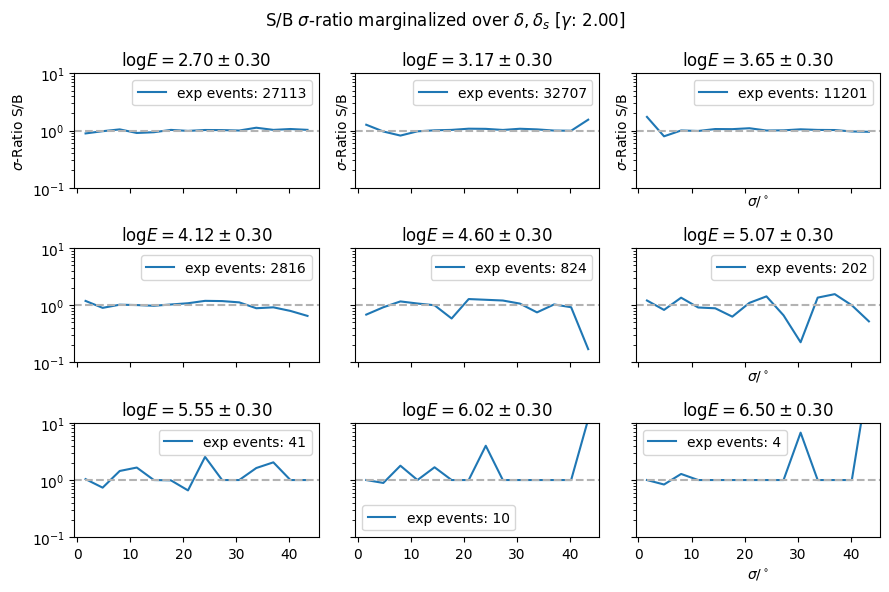

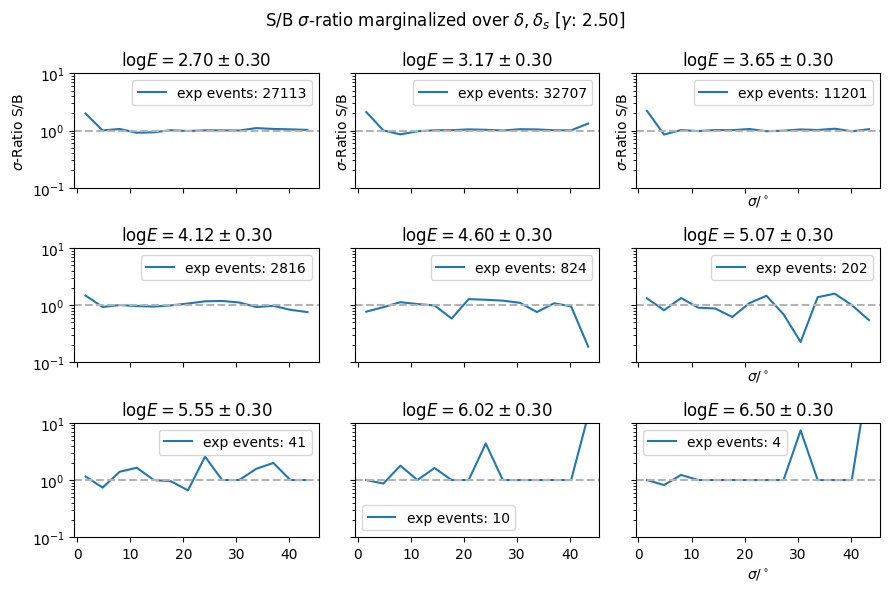

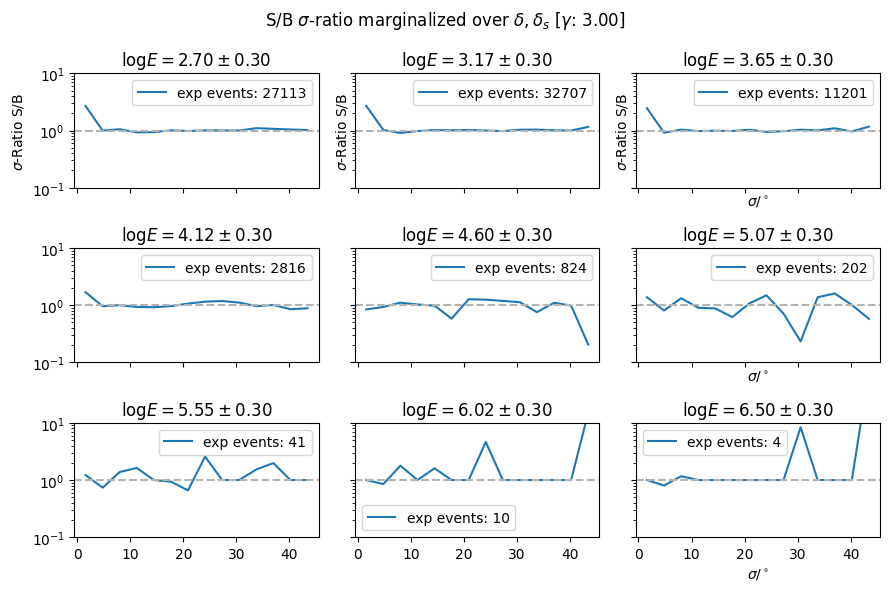

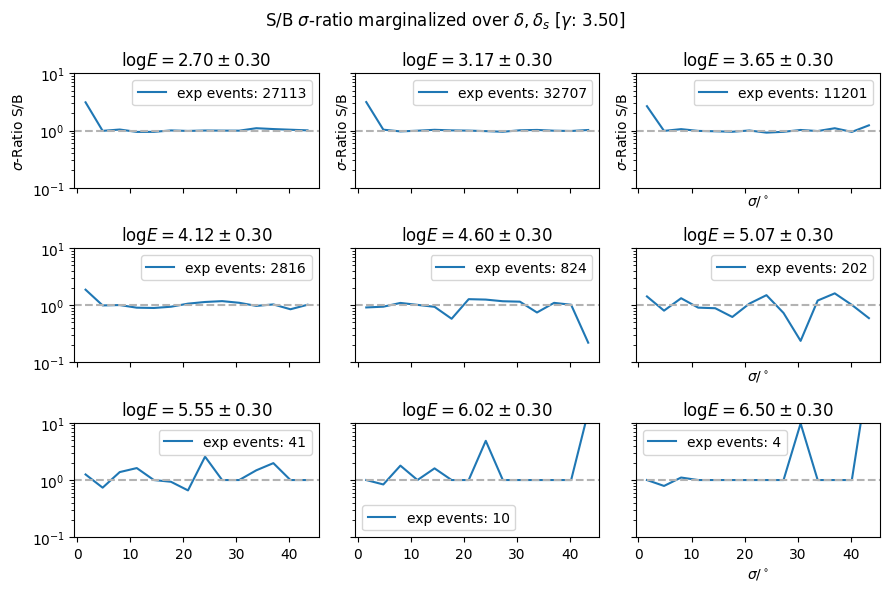

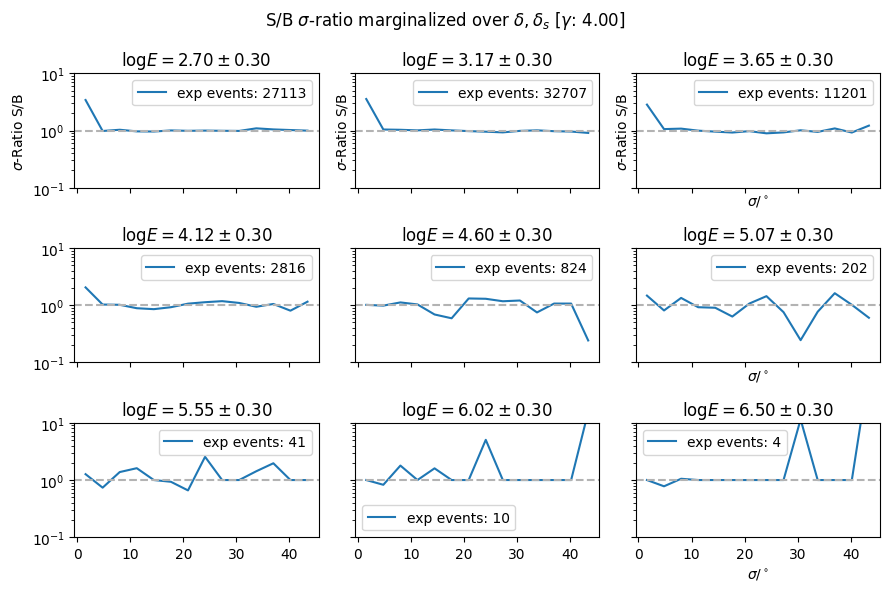

In [114]:
e_width = 0.3
bins = np.linspace(0, np.deg2rad(45), 15)
bin_mids = bins[:-1] + 0.5 * np.diff(bins)
dec_width = np.rad2deg(100)
dec_width_s = np.rad2deg(100)

bin_mids_deg = np.rad2deg(bin_mids)

for gamma in tqdm(np.linspace(1, 4, 7)):
#for gamma in tqdm([2.]):
    fig, axes = plt.subplots(3, 3, sharex=True, sharey=True, figsize=(9, 6))

    for e_mid, ax in zip(np.linspace(np.log10(500), 6.5, 9), axes.flatten()):
        h, h_bkg, ratio, n_bkg = get_ratio(
            e_mid=e_mid, gamma=gamma, dec_s_mid=np.deg2rad(0), dec_mid=np.deg2rad(0),
            dec_width=dec_width, dec_width_s=dec_width_s, e_width=e_width, bins=bins,
        )
        ax.plot(bin_mids_deg, ratio, label='exp events: {}'.format(n_bkg))
        ax.set_title('$\log E={:3.2f} \pm {:3.2f}$'.format(e_mid, e_width))
        ax.axhline(1, ls='--', color='0.7')
        ax.set_yscale('log')
        ax.set_ylim(1e-1, 1e1)
        ax.legend()
    
    for ax in axes[:, -1]:
        ax.set_xlabel('$\sigma / ^\circ$')
    for ax in axes[0, :]:
        ax.set_ylabel('$\sigma$-Ratio S/B')
    fig.suptitle('S/B $\sigma$-ratio marginalized over $\delta, \delta_s$ [$\gamma$: {:3.2f}]'.format(gamma))
    fig.tight_layout()
    fig.savefig(os.path.join(plot_dir, 'sigma_ratio__gamma_{:3.2f}.png'.format(gamma)))


#### Check Declination Dependence

  0%|          | 0/6 [00:00<?, ?it/s]

/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  if sys.path[0] == '':


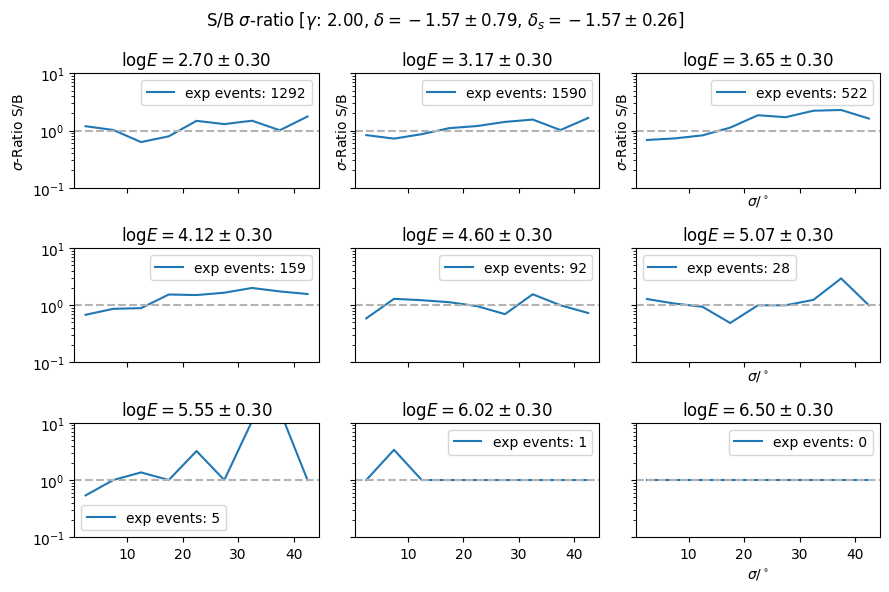

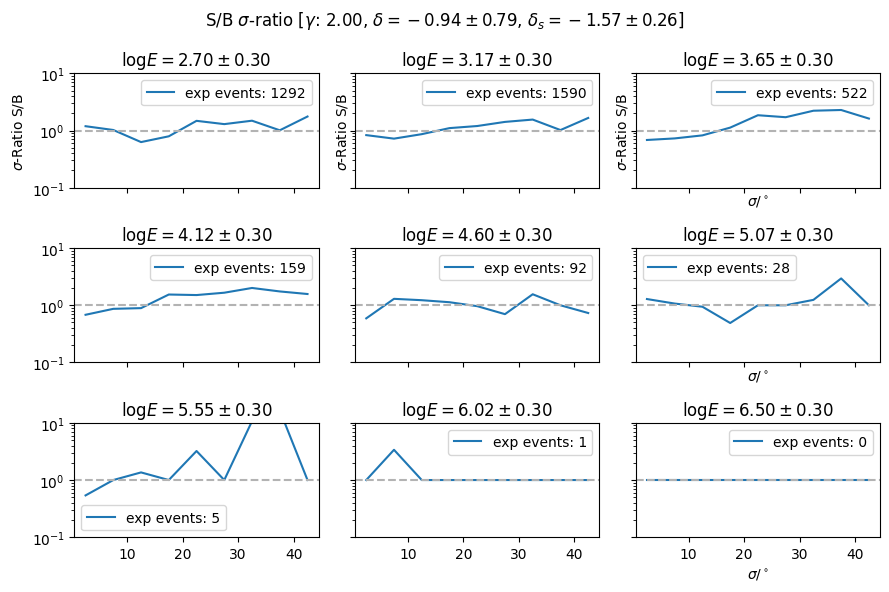

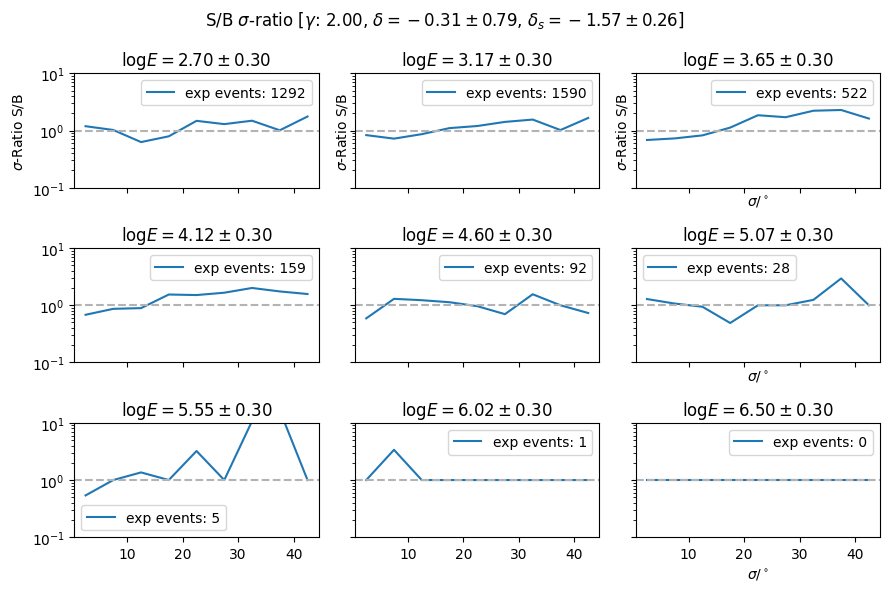

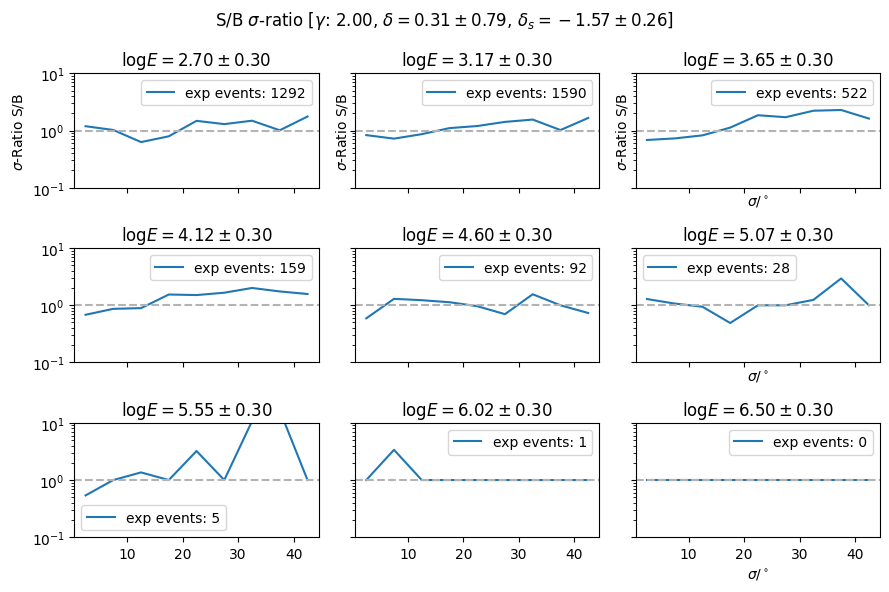

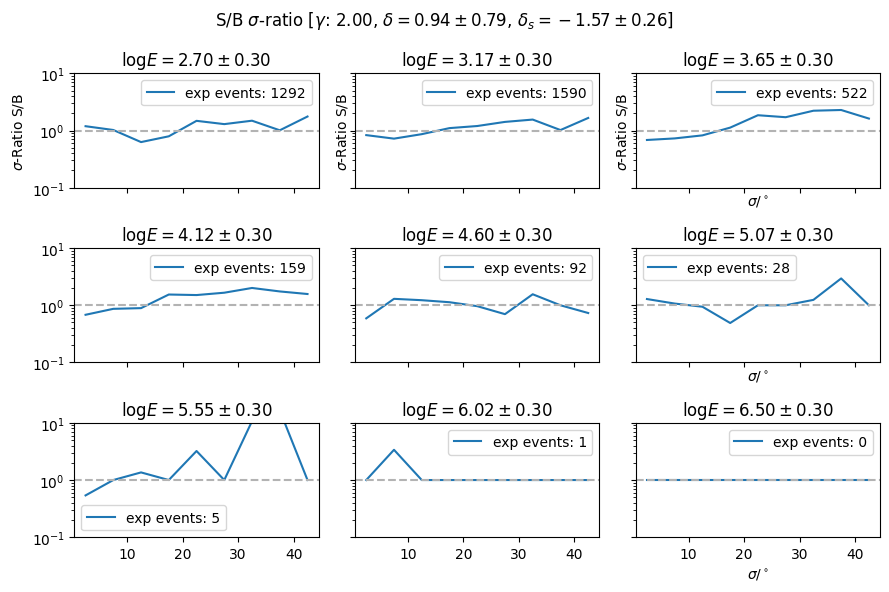

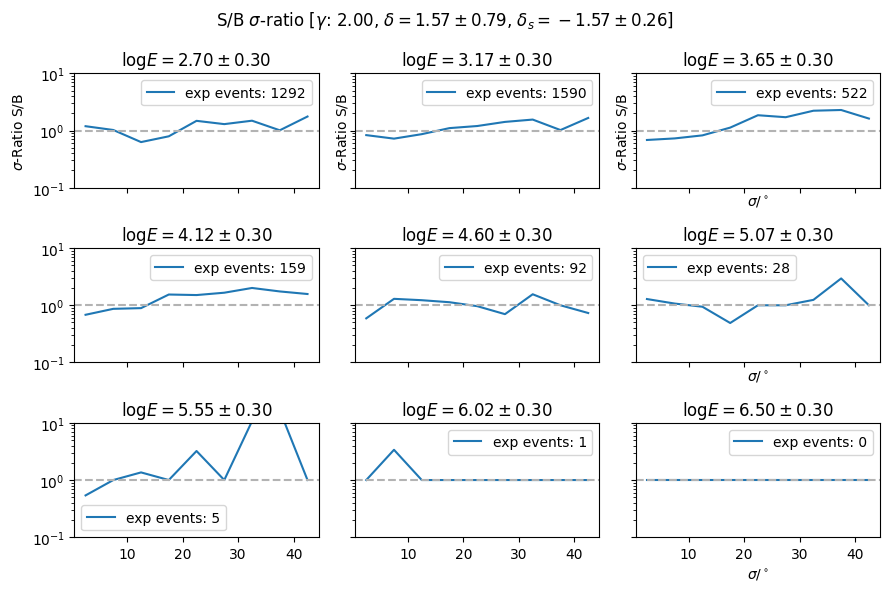

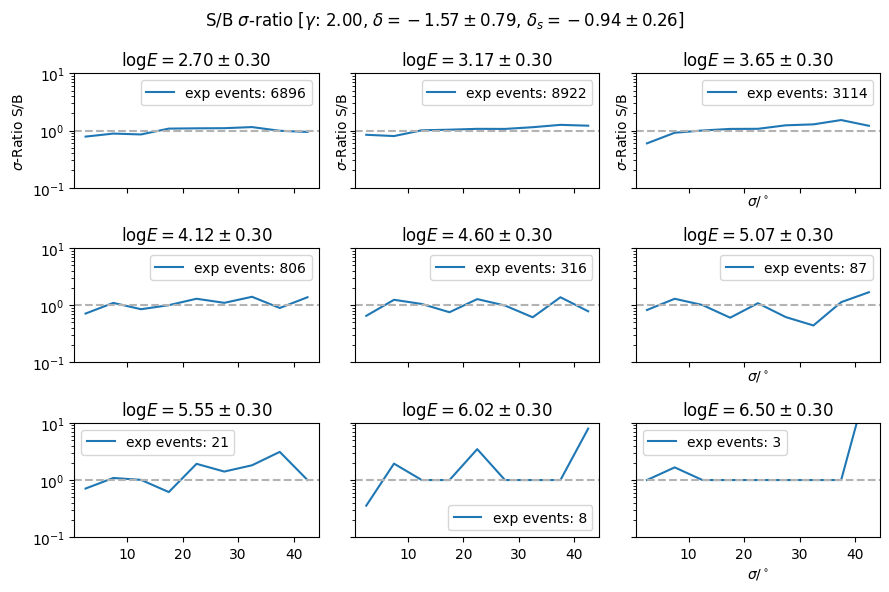

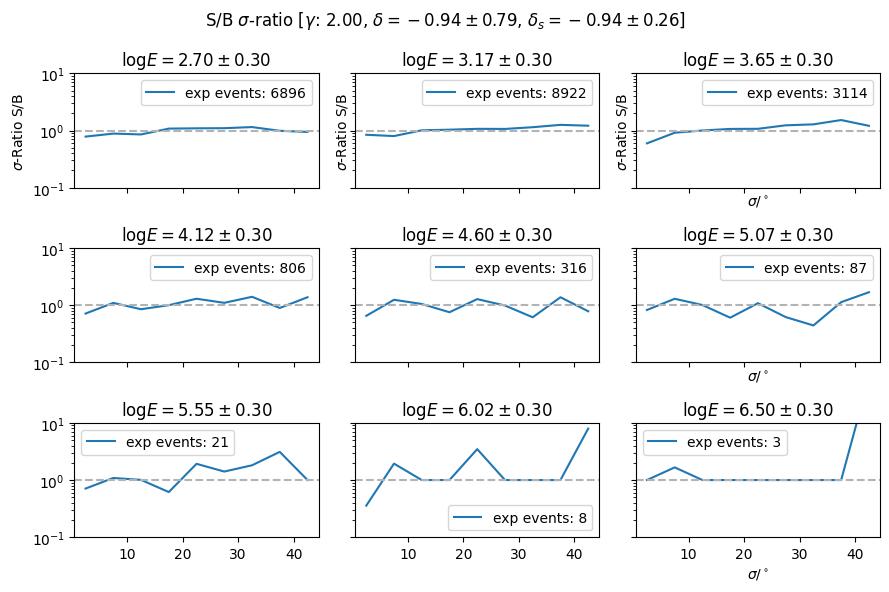

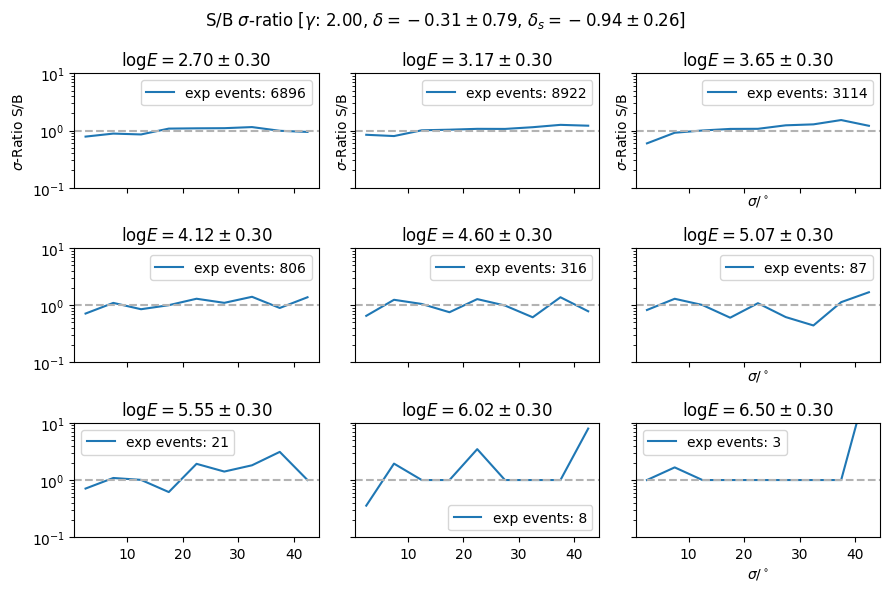

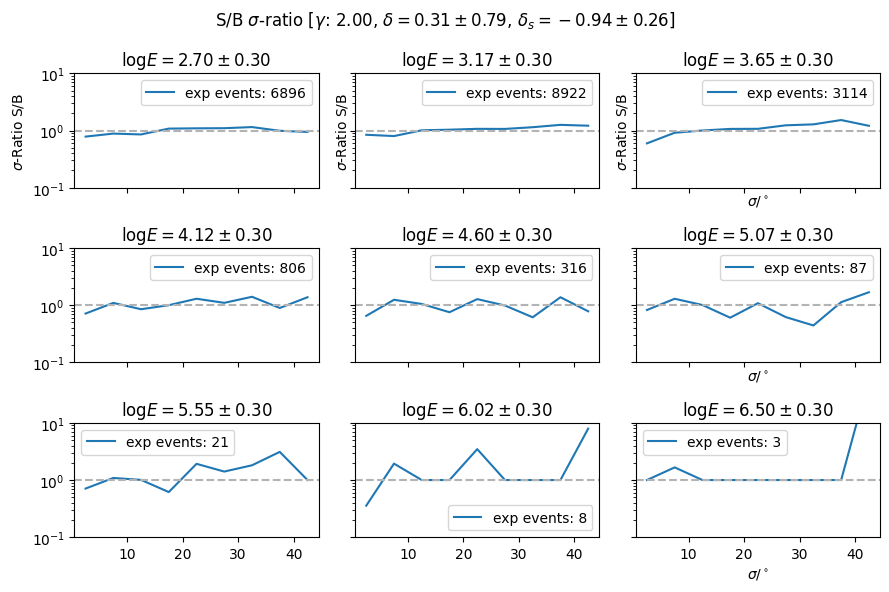

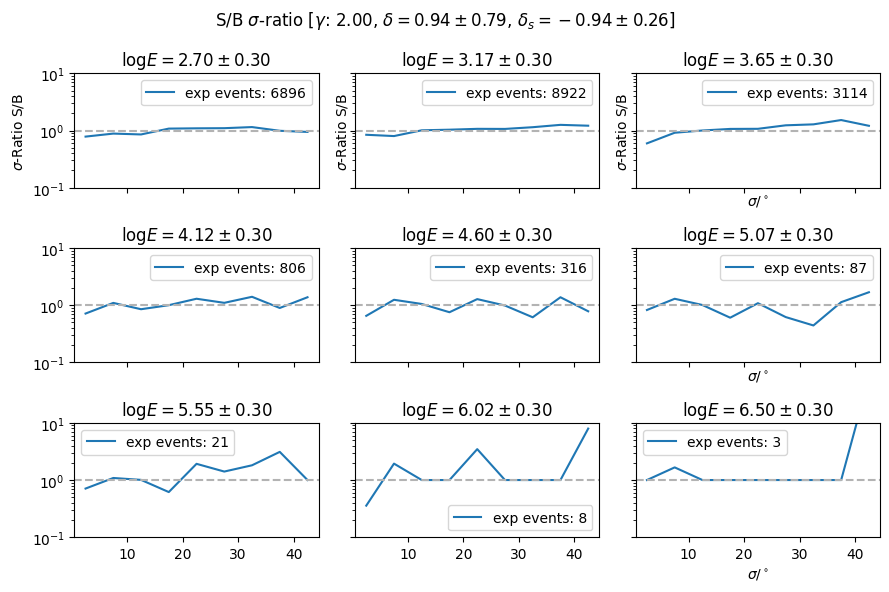

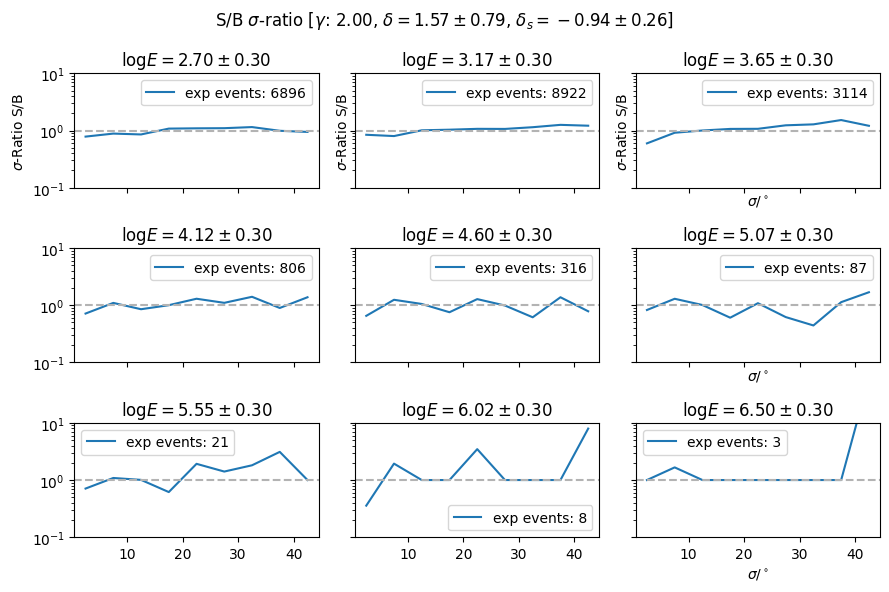

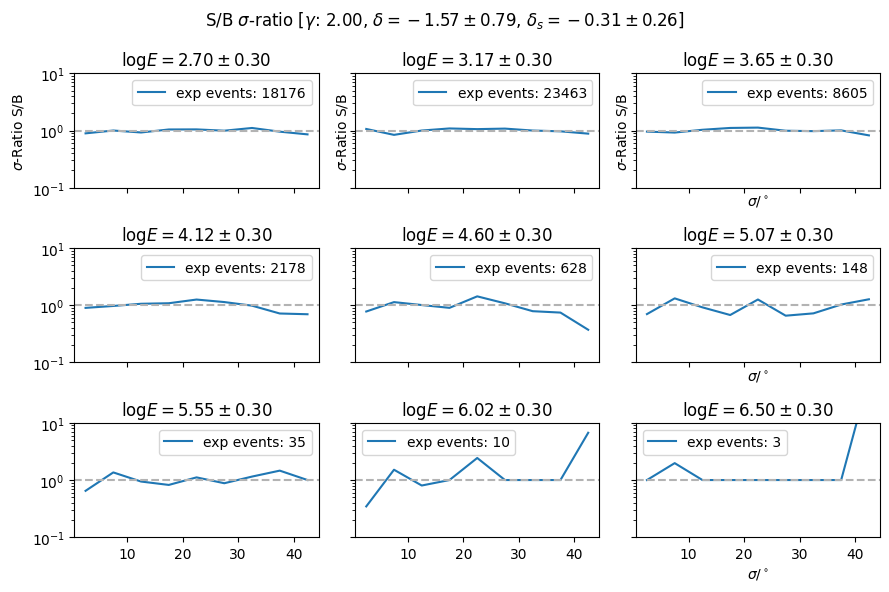

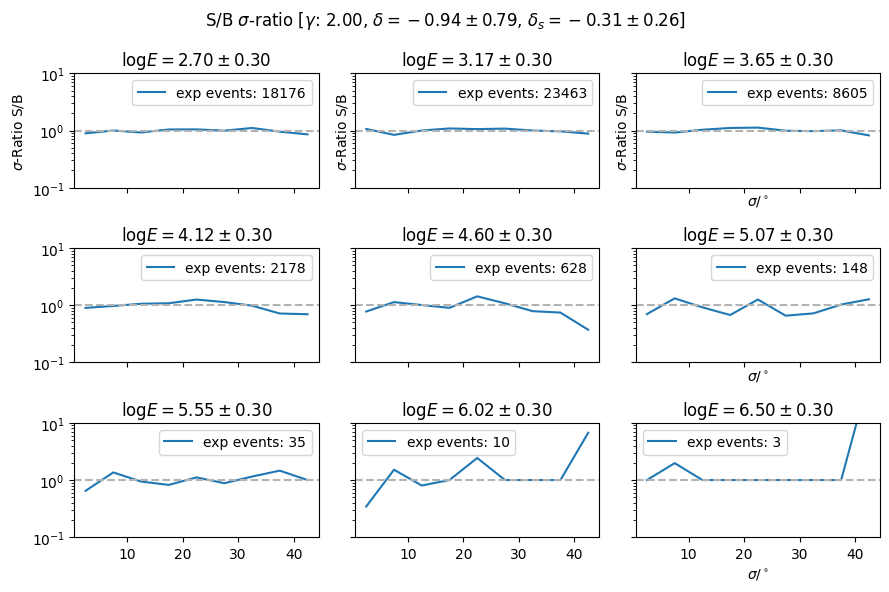

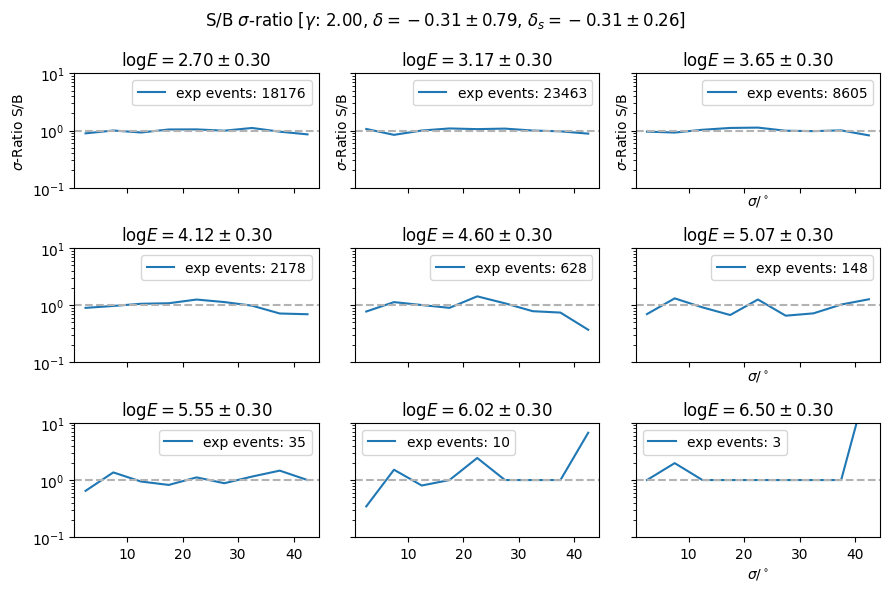

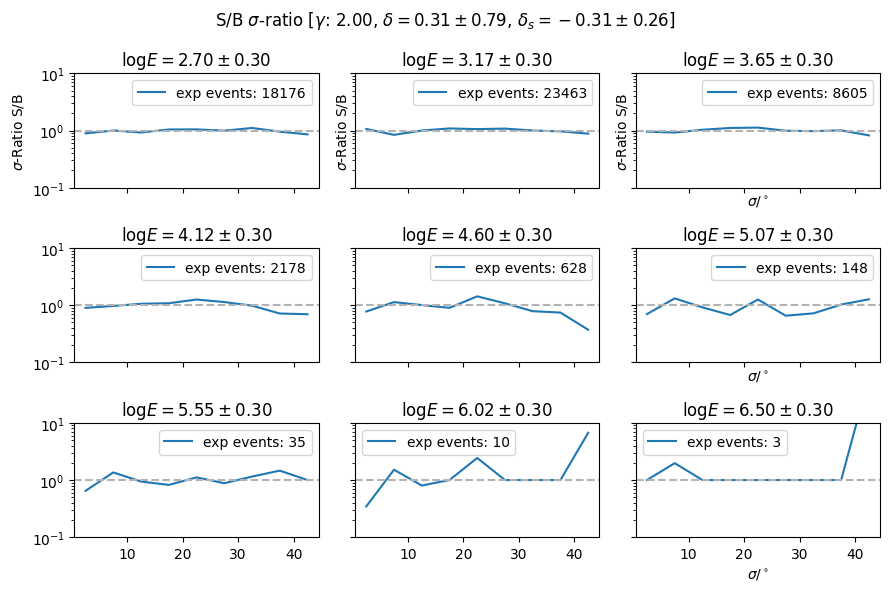

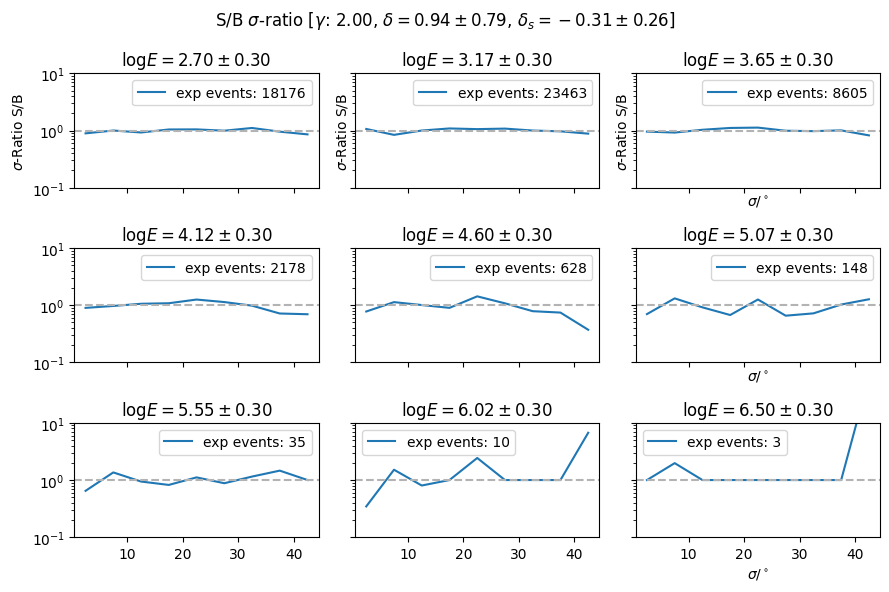

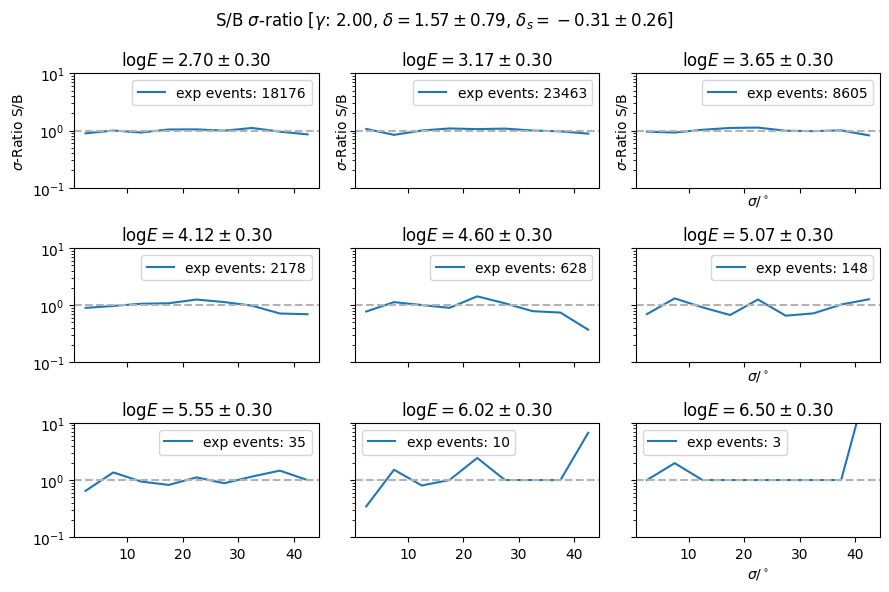

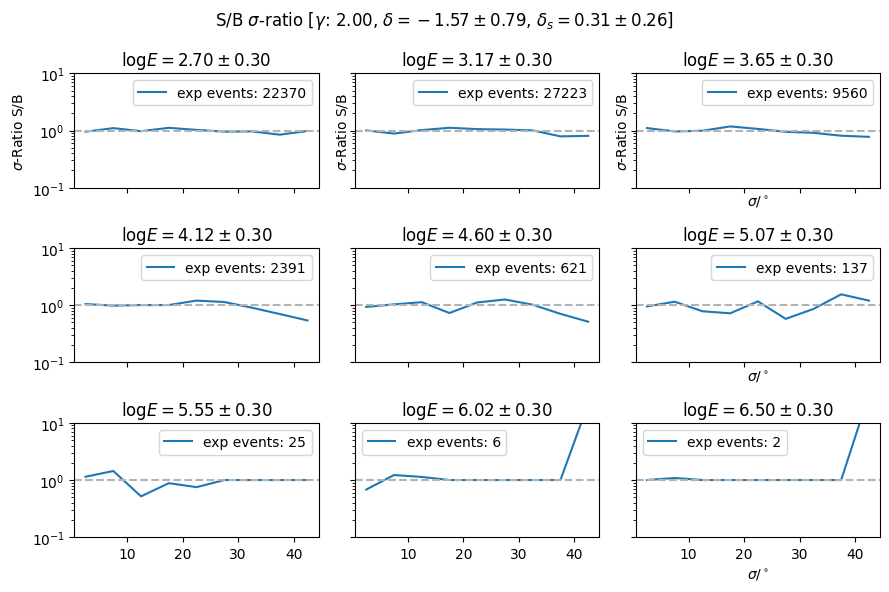

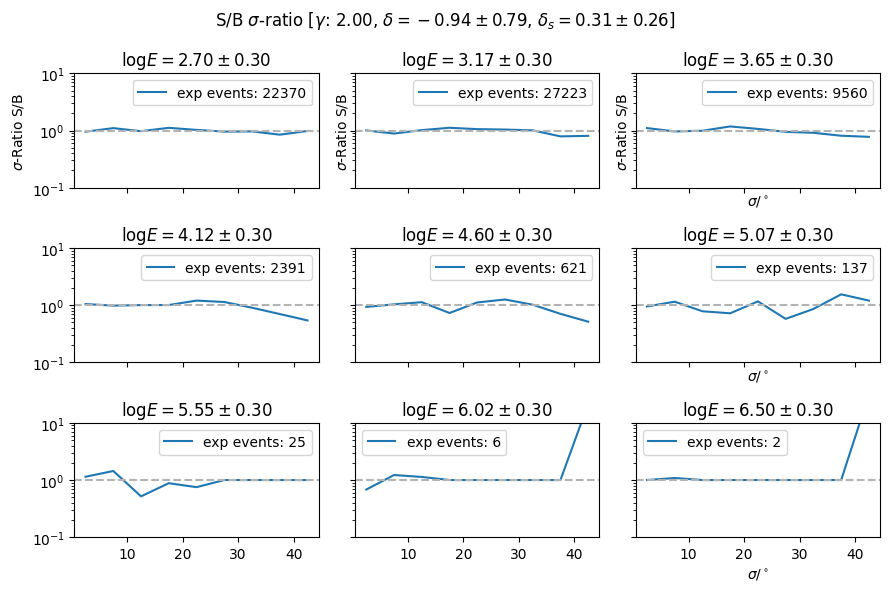

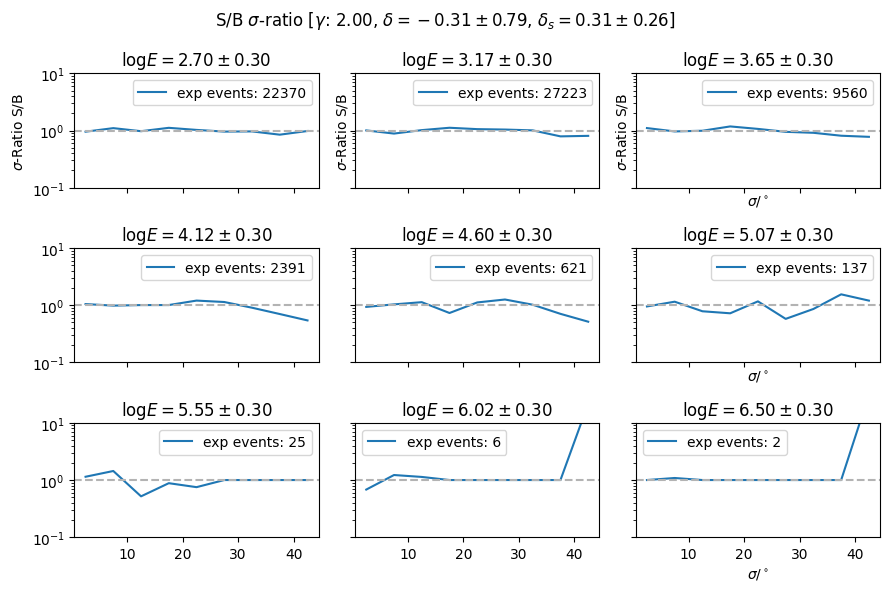

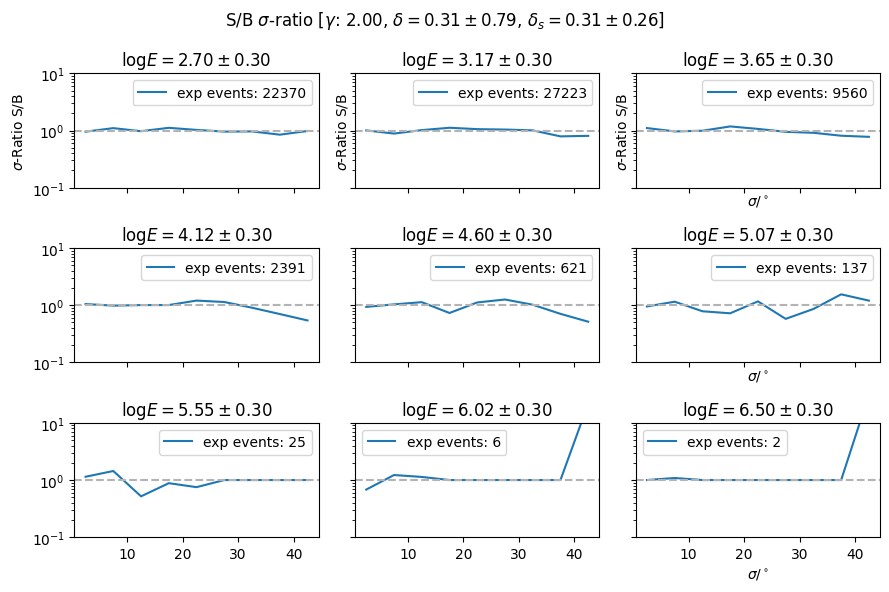

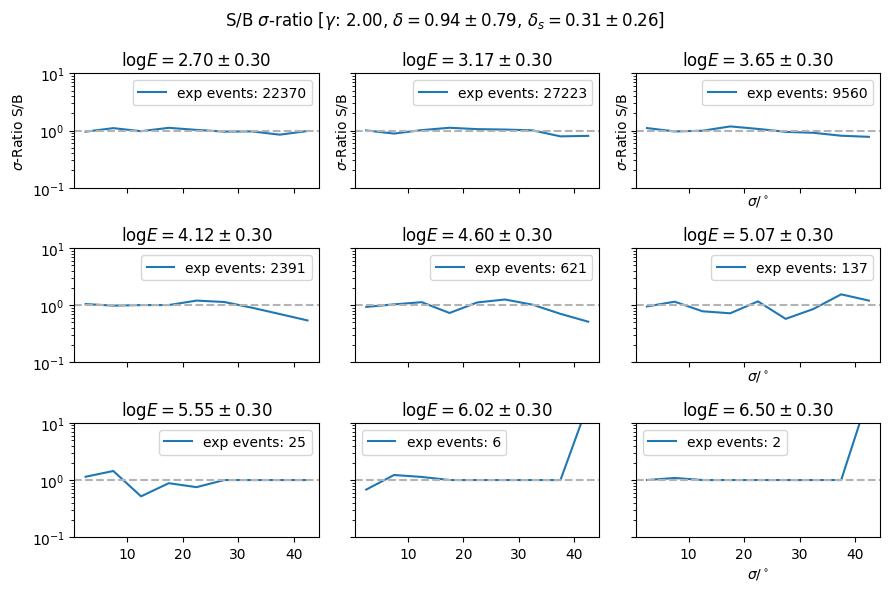

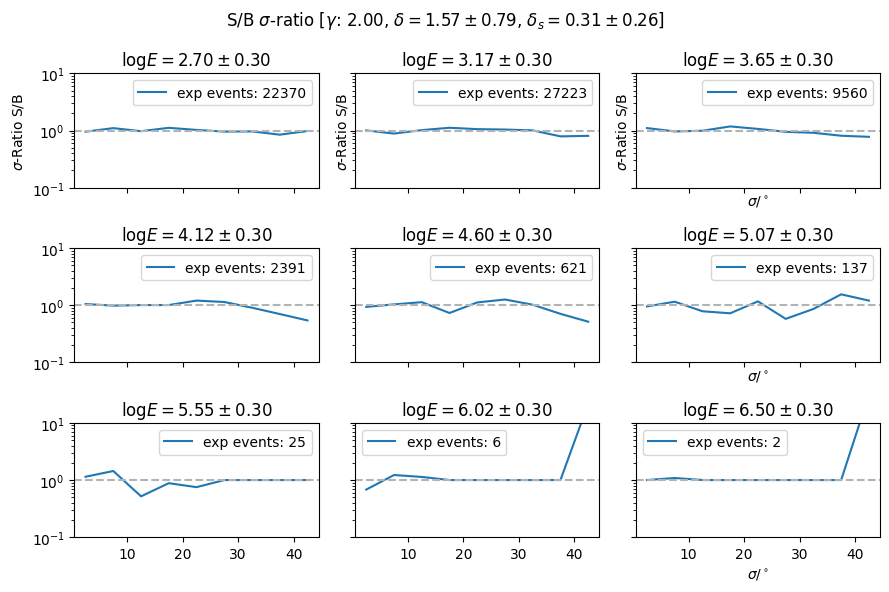

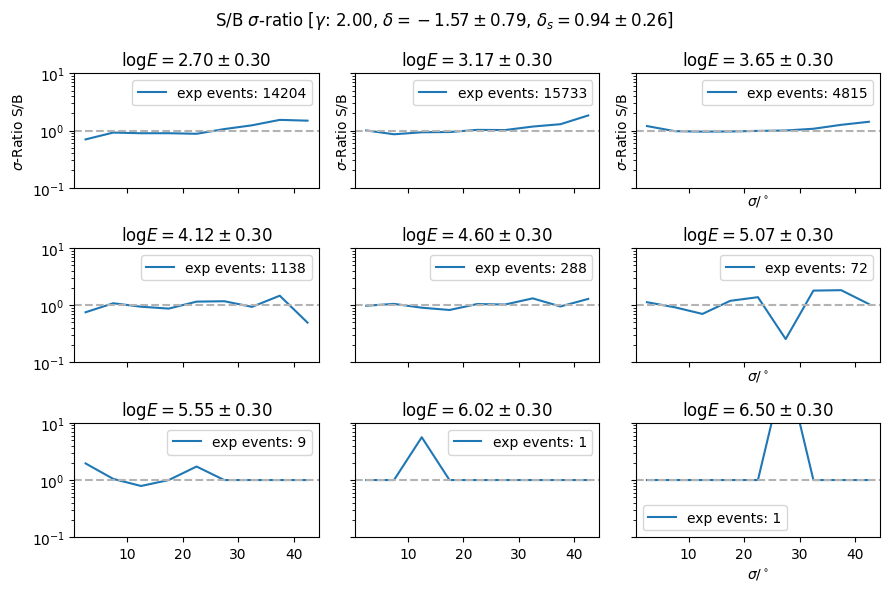

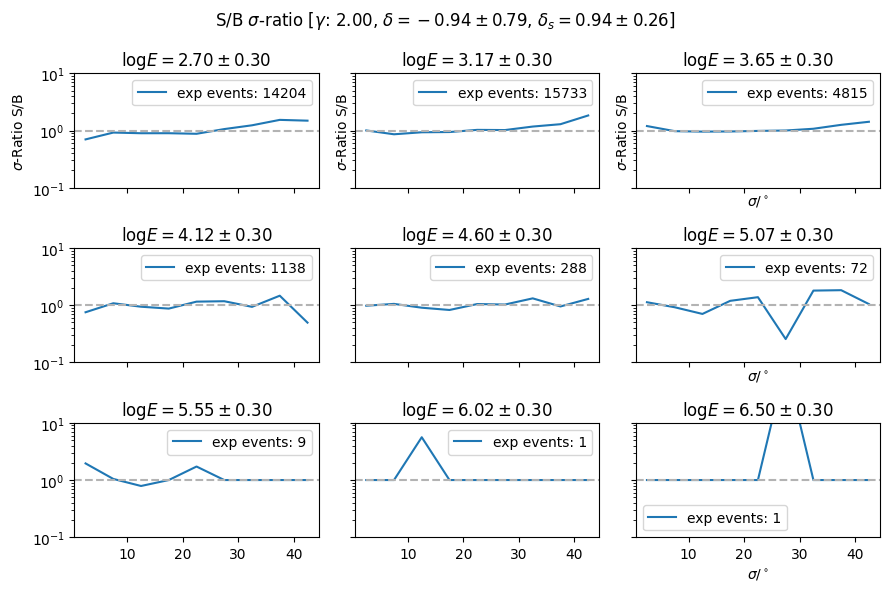

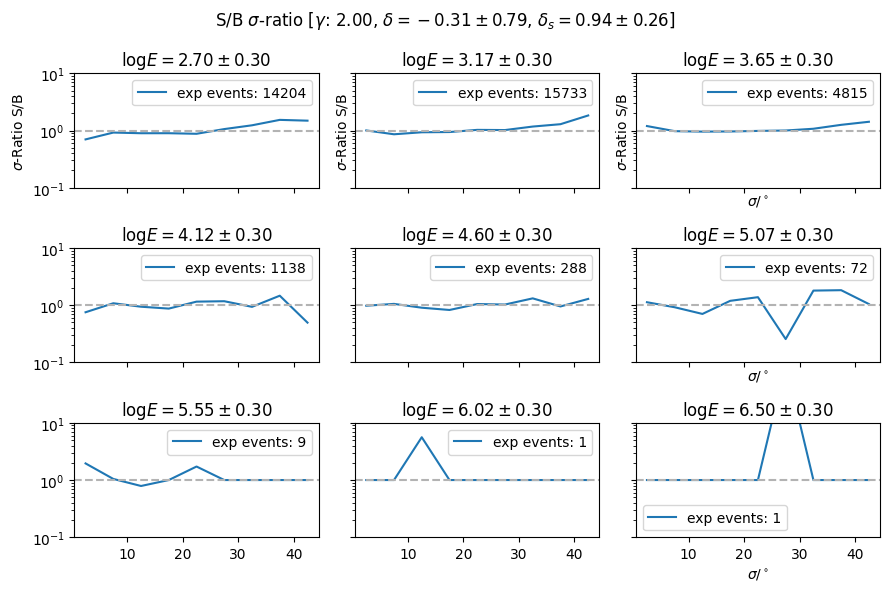

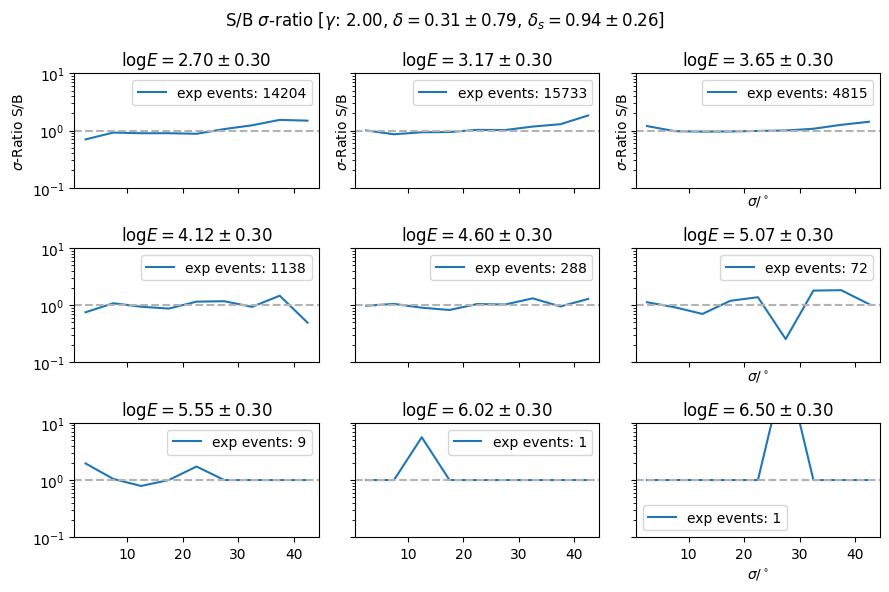

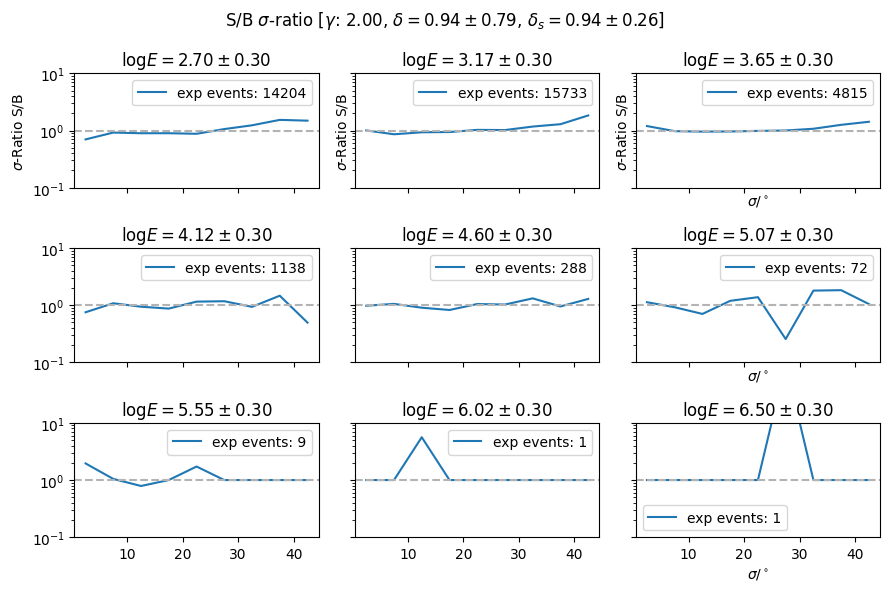

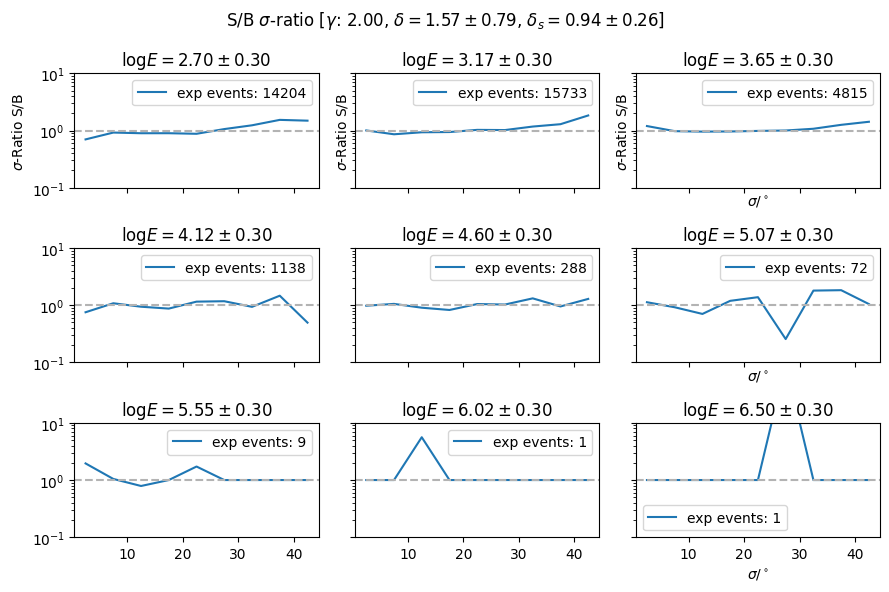

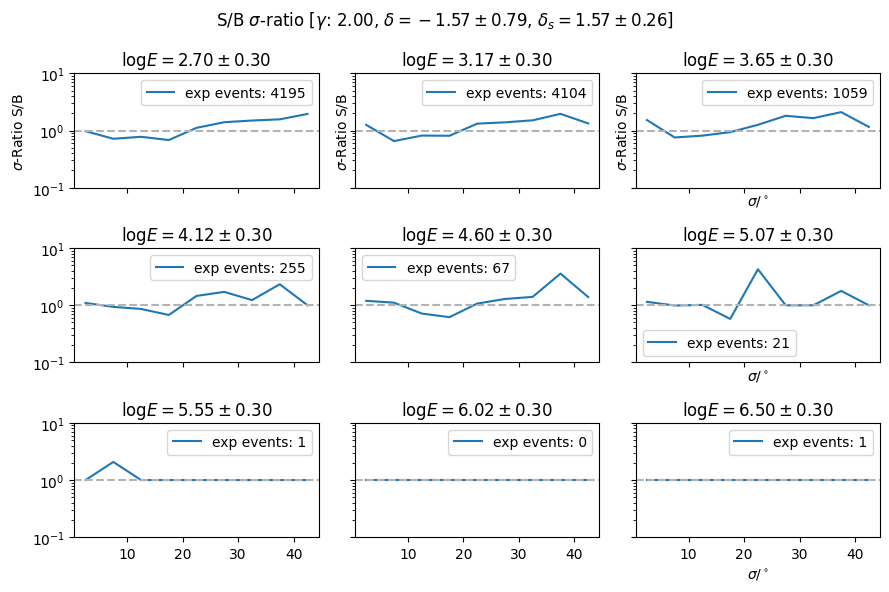

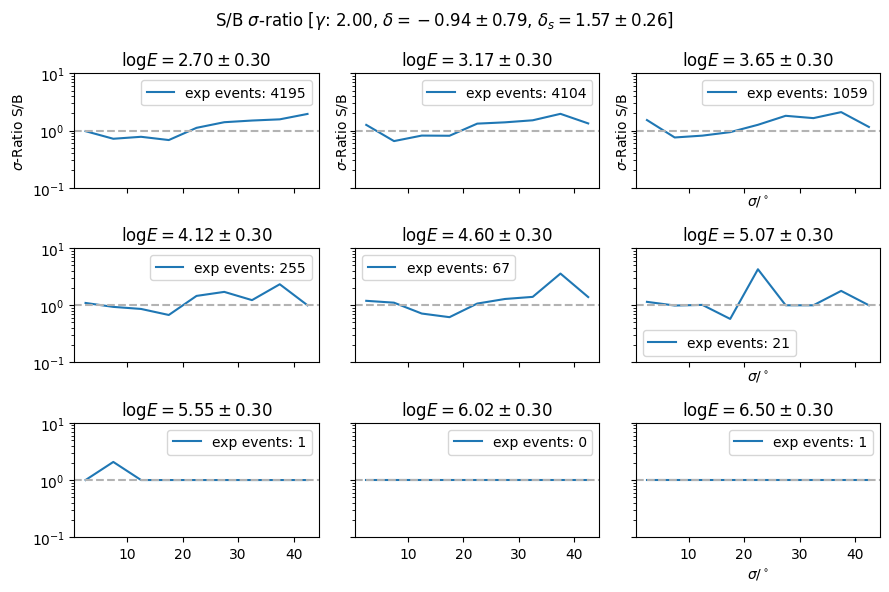

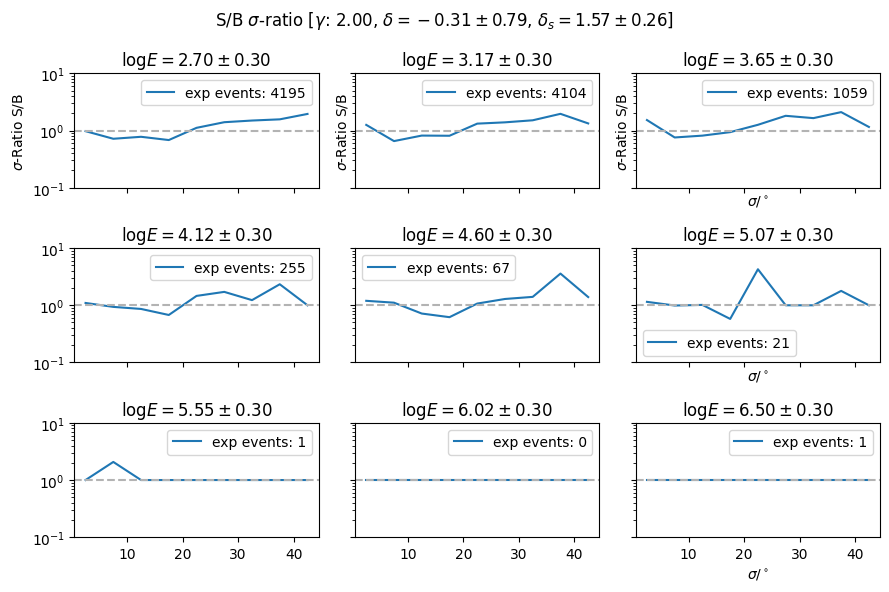

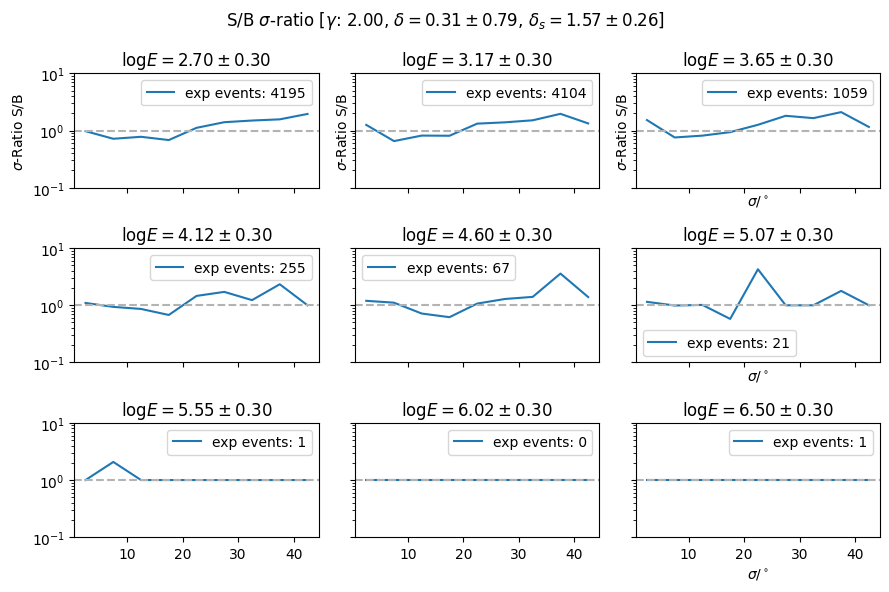

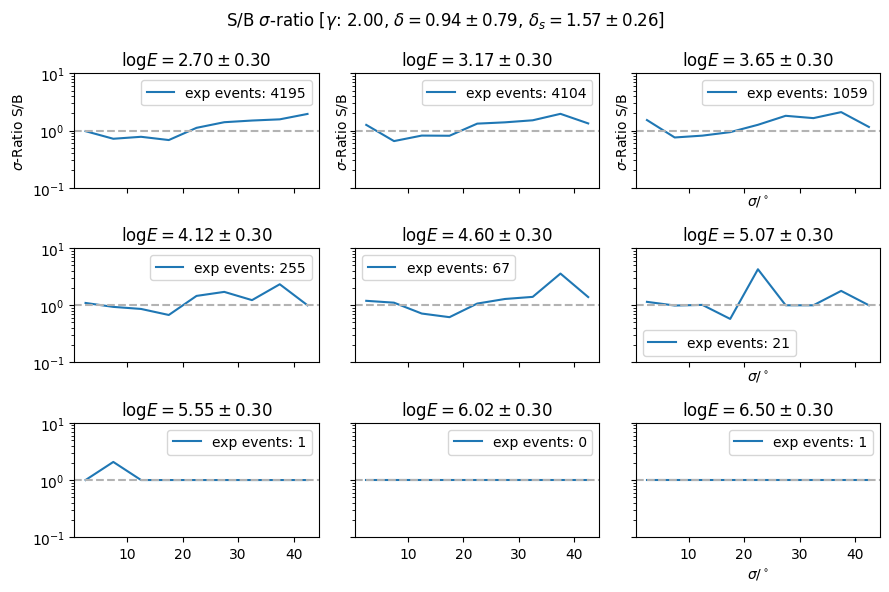

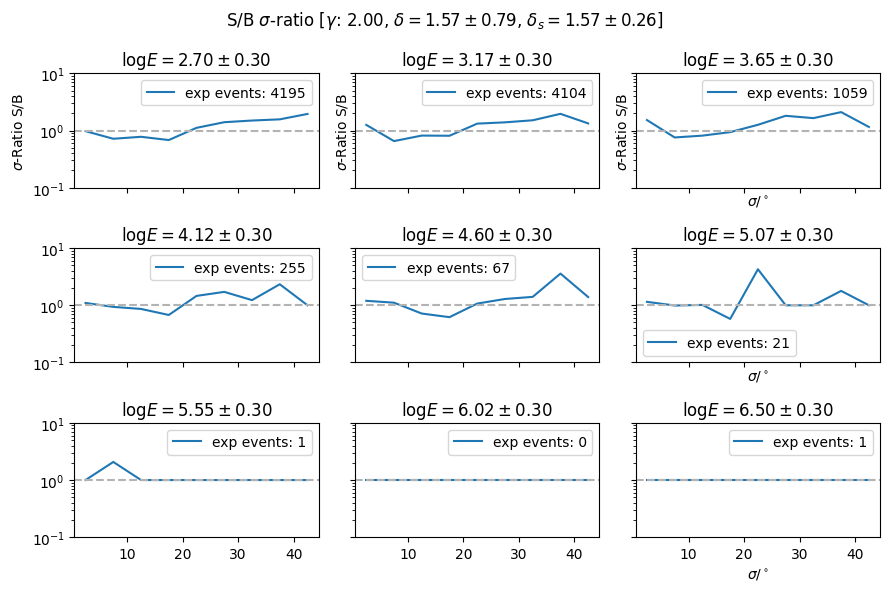

In [128]:
e_width = 0.3
bins = np.linspace(0, np.deg2rad(45), 10)
bin_mids = bins[:-1] + 0.5 * np.diff(bins)
dec_width = np.deg2rad(45)
dec_width_s = np.deg2rad(15)

bin_mids_deg = np.rad2deg(bin_mids)

for dec_s_mid in tqdm(np.linspace(-np.pi/2., np.pi/2., 6)):
    for dec_mid in np.linspace(-np.pi/2., np.pi/2., 6):
        for gamma in [2.]:
            fig, axes = plt.subplots(3, 3, sharex=True, sharey=True, figsize=(9, 6))

            for e_mid, ax in zip(np.linspace(np.log10(500), 6.5, 9), axes.flatten()):
                h, h_bkg, ratio, n_bkg = get_ratio(
                    e_mid=e_mid, gamma=gamma, dec_s_mid=dec_s_mid, dec_mid=dec_mid,
                    dec_width=dec_width, e_width=e_width, bins=bins,
                )
                ax.plot(bin_mids_deg, ratio, label='exp events: {}'.format(n_bkg))
                ax.set_title('$\log E={:3.2f} \pm {:3.2f}$'.format(e_mid, e_width))
                ax.axhline(1, ls='--', color='0.7')
                ax.set_yscale('log')
                ax.set_ylim(1e-1, 1e1)
                ax.legend()

            for ax in axes[:, -1]:
                ax.set_xlabel('$\sigma / ^\circ$')
            for ax in axes[0, :]:
                ax.set_ylabel('$\sigma$-Ratio S/B')
            fig.suptitle('S/B $\sigma$-ratio [$\gamma$: {:3.2f}, $\delta={:3.2f} \pm {:3.2f}$, $\delta_s={:3.2f} \pm {:3.2f}$]'.format(
                gamma, dec_mid, dec_width, dec_s_mid, dec_width_s))
            fig.tight_layout()
            fig.savefig(os.path.join(plot_dir, 'sigma_ratio__gamma_{:3.2f}_dec_{:3.2f}_dec_s_{:3.2f}.png'.format(
                gamma, dec_mid, dec_s_mid)))


## Assumption 3: $\delta_s \approx \delta$

3. $S(E | \gamma, \sin{\delta_s}) \approx S(E | \gamma, \sin{\delta})$. For simplicity, we typically build the signal energy PDF conditional on the reconstructed event declination $\delta$ rather than the assumed source declintation $\delta_s$. For event samples with small angular errors such as track, this is mostly a good assumption. If the event is well reconstructed, $\delta_s \approx \delta$ is valid. Events that are further away from the source for which this approximation does not hold, are heavily down-weighted by the spatial signal term. These events for which this assumption does not hold therefore do not contribute much to the overall likelihood. Therefore, this is usually a good enough approximation, but it may cause issues for event samples with large angular uncertainties such as cascades.

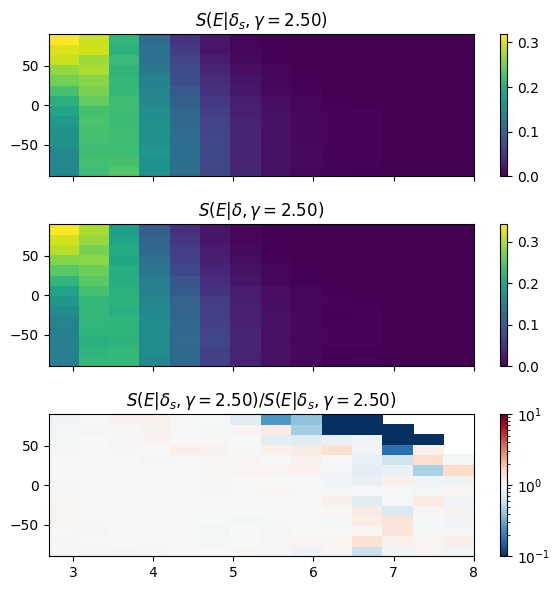

In [154]:
gamma = 2.5
bins = (np.linspace(np.log10(500), 8, 15), np.linspace(-np.pi/2., np.pi/2., 15))

weights = reweight(
    ow=a.sig.oneweight,
    energy=a.sig.true_energy,
    gamma=gamma,
)

h_s, xedges, yedges = np.histogram2d(a.sig.log10energy, a.sig.true_dec, bins=bins, weights=weights)
h, xedges, yedges = np.histogram2d(a.sig.log10energy, a.sig.dec, bins=bins, weights=weights)

# normalize along energy
h_s /= np.sum(h_s, axis=0, keepdims=True)
h /= np.sum(h, axis=0, keepdims=True)

fig, axes = plt.subplots(3, 1, sharex=True, figsize=(6, 6))

# plot source dec pdf
im = axes[0].pcolormesh(xedges, np.rad2deg(yedges), h_s.T)
cb = plt.colorbar(im, ax=axes[0])
axes[0].set_title('$S(E | \delta_s, \gamma={:3.2f})$'.format(gamma))

# plot dec pdf
im = axes[1].pcolormesh(xedges, np.rad2deg(yedges), h.T)
cb = plt.colorbar(im, ax=axes[1])
axes[1].set_title('$S(E | \delta, \gamma={:3.2f})$'.format(gamma))

# plot ratio
im = axes[2].pcolormesh(
    xedges, np.rad2deg(yedges), h_s.T / h.T, 
    cmap='RdBu_r', norm=mpl.colors.LogNorm(vmin=1e-1, vmax=1e1),
)
cb = plt.colorbar(im, ax=axes[2])
axes[2].set_title('$S(E | \delta_s, \gamma={:3.2f}) / S(E | \delta_s, \gamma={:3.2f})$'.format(gamma, gamma))

fig.tight_layout()

#### Create spline fit to PDFs

In [268]:
gamma = 2.5
bins = (a.energy_pdf_ratio_model.hkw['bins'][1], np.arcsin(a.energy_pdf_ratio_model.hkw['bins'][0]))
bins_bkg_dec = a.bg_space_param.hkw['bins']

weights = reweight(
    ow=a.sig.oneweight,
    energy=a.sig.true_energy,
    gamma=gamma,
)

b_sindec = hl.hist(a.bg_data.sindec, bins=bins_bkg_dec).normalize()
b = hl.hist((a.bg_data.log10energy, a.bg_data.dec), bins=bins).normalize(0)
h = hl.hist((a.sig.log10energy, a.sig.dec), bins=bins, weights=weights).normalize(0)
h_s = hl.hist((a.sig.log10energy, a.sig.true_dec), bins=bins, weights=weights).normalize(0)
spline = h.spline_fit(log=True, s=0, kx=1, ky=1)
spline_s = h_s.spline_fit(log=True, s=0, kx=1, ky=1)
spline_b = b.spline_fit(log=True, s=0, kx=1, ky=1)
spline_b_sindec = b_sindec.spline_fit(log=True, s=0, k=1)


def get_log_pdf_bkg_sindec(sindec):
    return spline_b_sindec(sindec)

def get_log_pdf_b(log10energy, dec):
    return spline_b(log10energy, dec)

def get_log_pdf(log10energy, dec):
    return spline(log10energy, dec)

def get_log_pdf_s(log10energy, true_dec):
    return spline(log10energy, true_dec)


#### Check impact at various declinations of $\delta \neq \delta_s$

Check impact of $S(E | \gamma, \sin{\delta_s}) \approx S(E | \gamma, \sin{\delta})$

Sindec: -1.000
E: 3654.170 | E_csky: 3647.170 | S/B: 884.293 | S/B_csky: 877.293 | True/csky: 100.192% 100.798% nan% nan%
[BKG] E: 181.657 | E_csky: 182.491 | S/B: -139.480 | S/B_csky: -138.646 | True/csky: 99.543% 
Sindec: -0.800
E: 4375.527 | E_csky: 4371.141 | S/B: 941.454 | S/B_csky: 937.069 | True/csky: 100.100% 100.468% nan% nan%
[BKG] E: 281.251 | E_csky: 282.056 | S/B: -224.122 | S/B_csky: -223.317 | True/csky: 99.715% 
Sindec: -0.600
E: 4989.223 | E_csky: 4980.650 | S/B: 1044.022 | S/B_csky: 1035.449 | True/csky: 100.172% 100.828% nan% nan%
[BKG] E: 500.283 | E_csky: 502.810 | S/B: -410.924 | S/B_csky: -408.397 | True/csky: 99.497% 
Sindec: -0.400
E: 5299.798 | E_csky: 5285.520 | S/B: 835.271 | S/B_csky: 820.992 | True/csky: 100.270% 101.739% 100.155% 100.479%
[BKG] E: 768.264 | E_csky: 769.687 | S/B: -560.261 | S/B_csky: -558.838 | True/csky: 99.815% 
Sindec: -0.200
E: 5570.748 | E_csky: 5552.046 | S/B: 490.659 | S/B_csky: 471.956 | True/csky: 100.337% 103.963% 100.214% 98.35

/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/ipykernel_launcher.py:38: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


E: 3909.118 | E_csky: 3948.894 | S/B: -95.136 | S/B_csky: -55.360 | True/csky: 98.993% 171.849% nan% nan%
[BKG] E: 690.787 | E_csky: 665.157 | S/B: -259.498 | S/B_csky: -285.127 | True/csky: 103.853% 


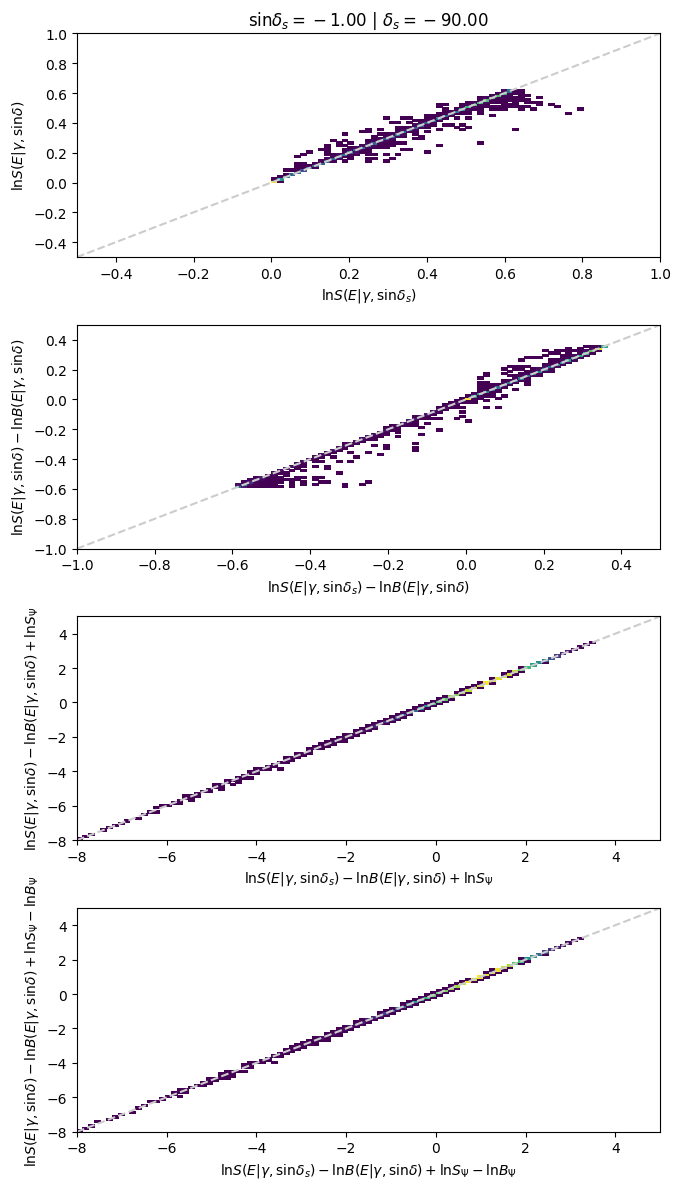

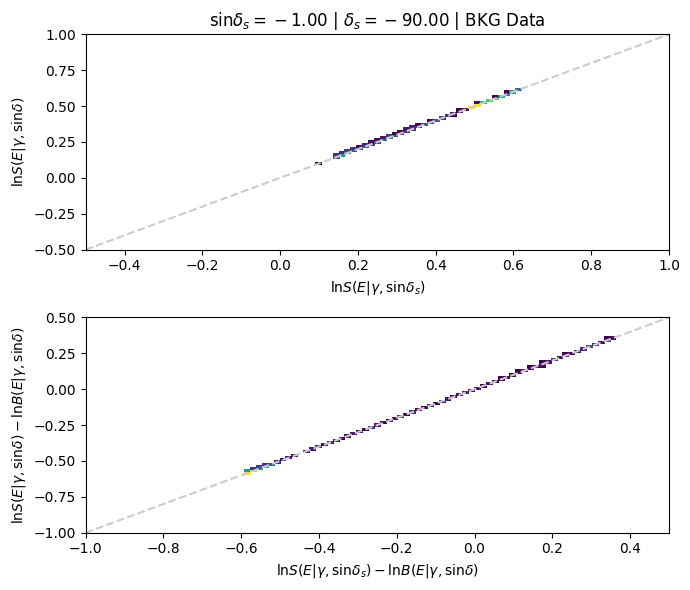

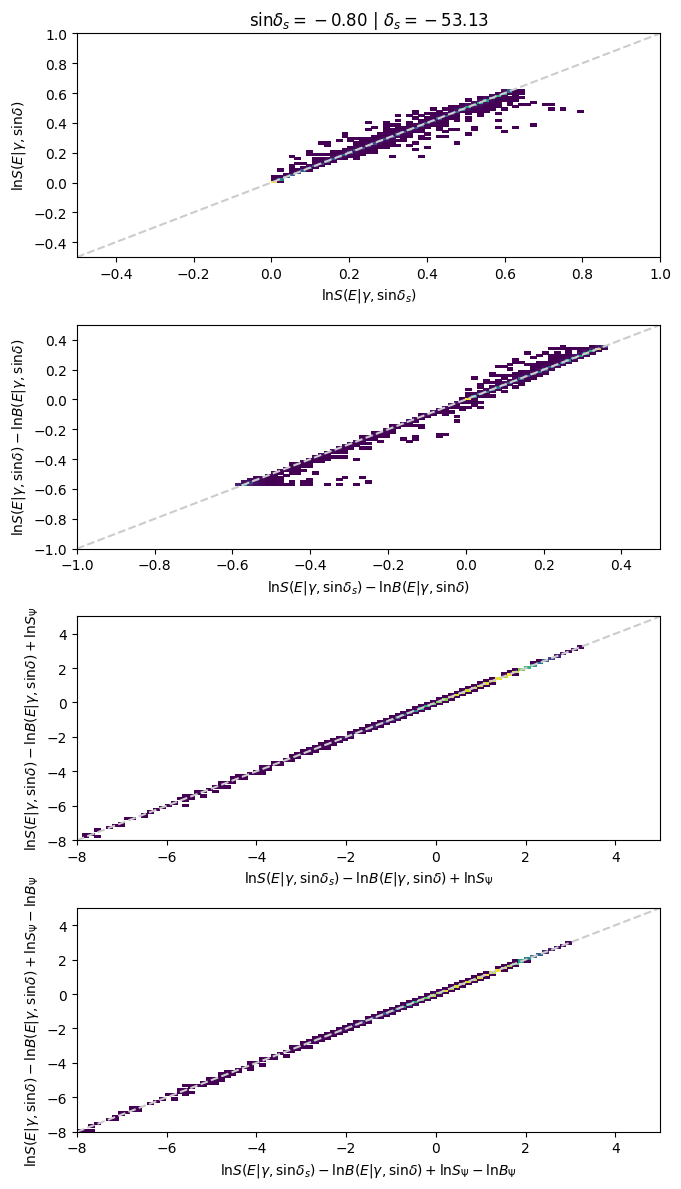

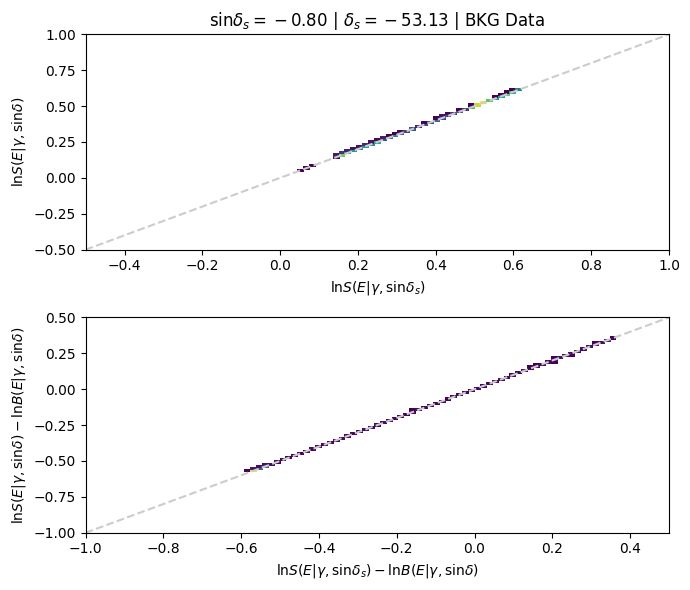

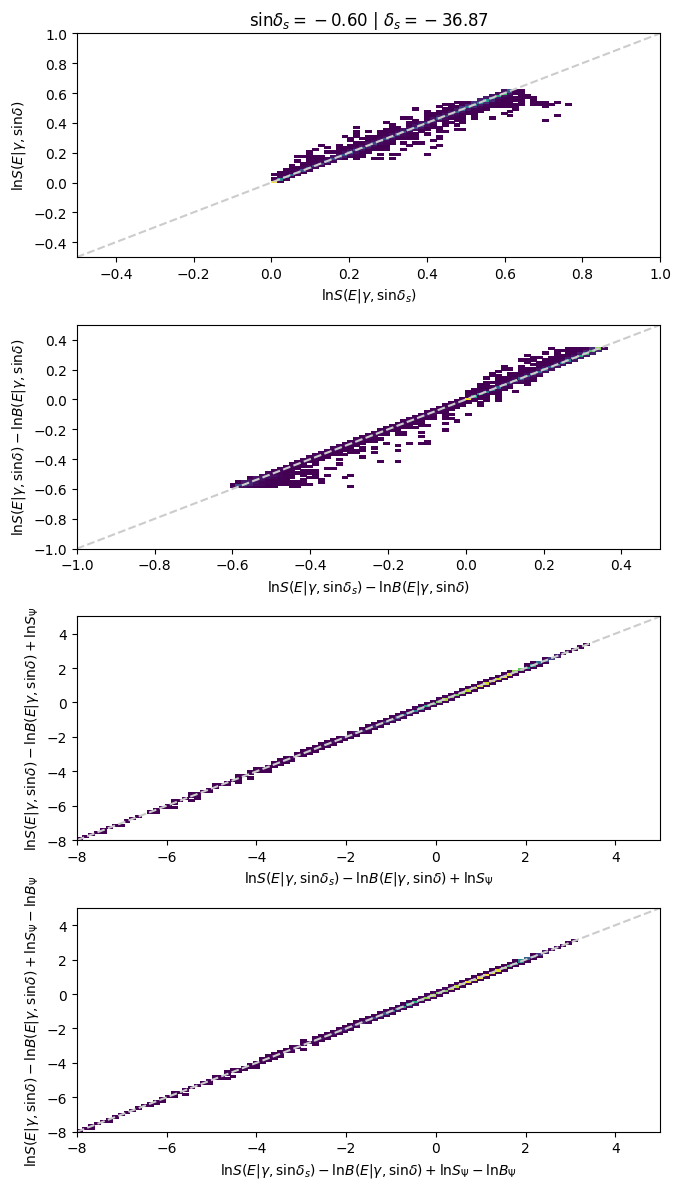

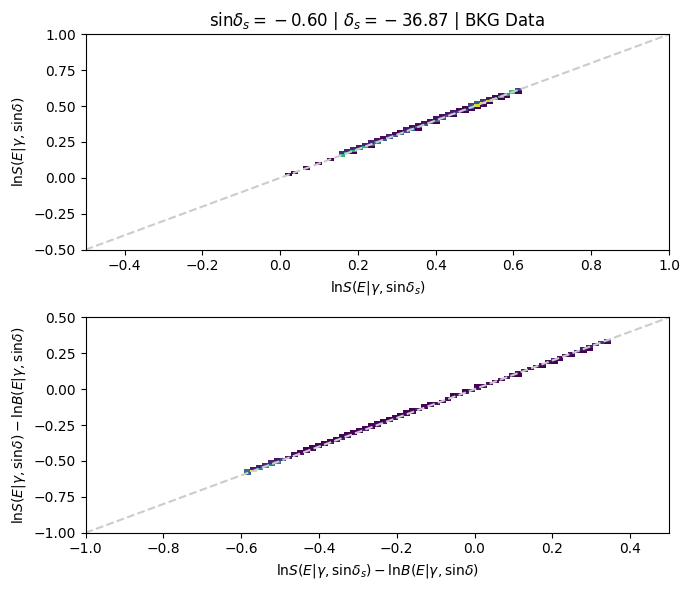

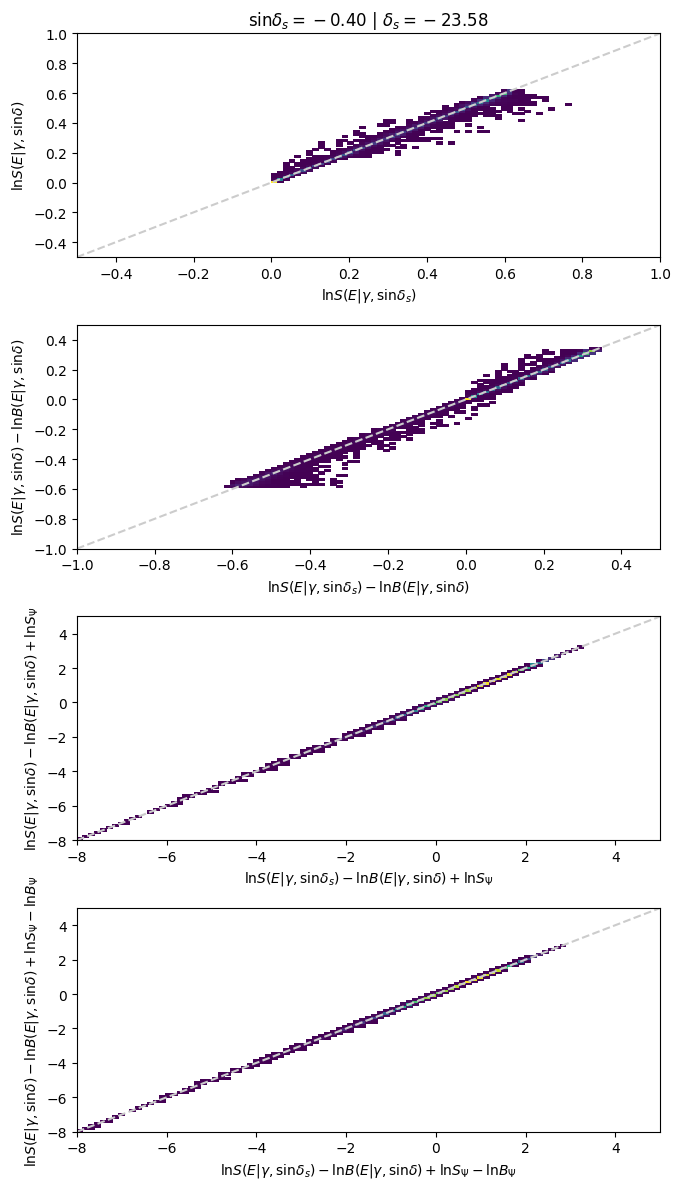

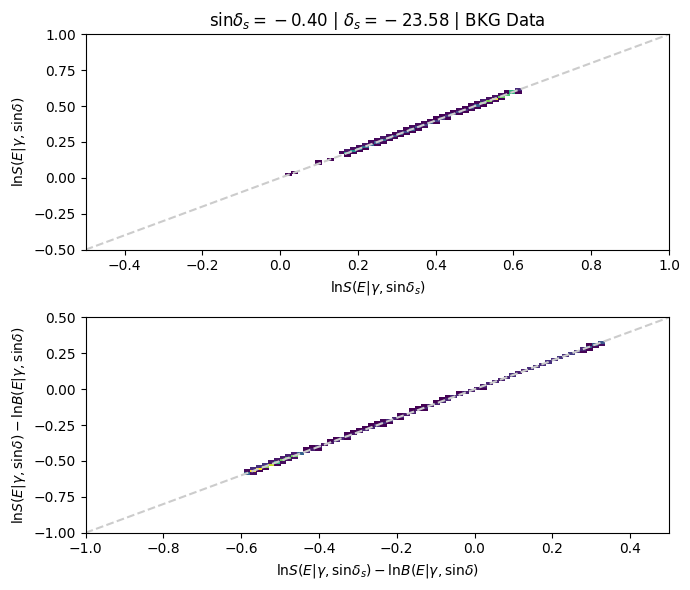

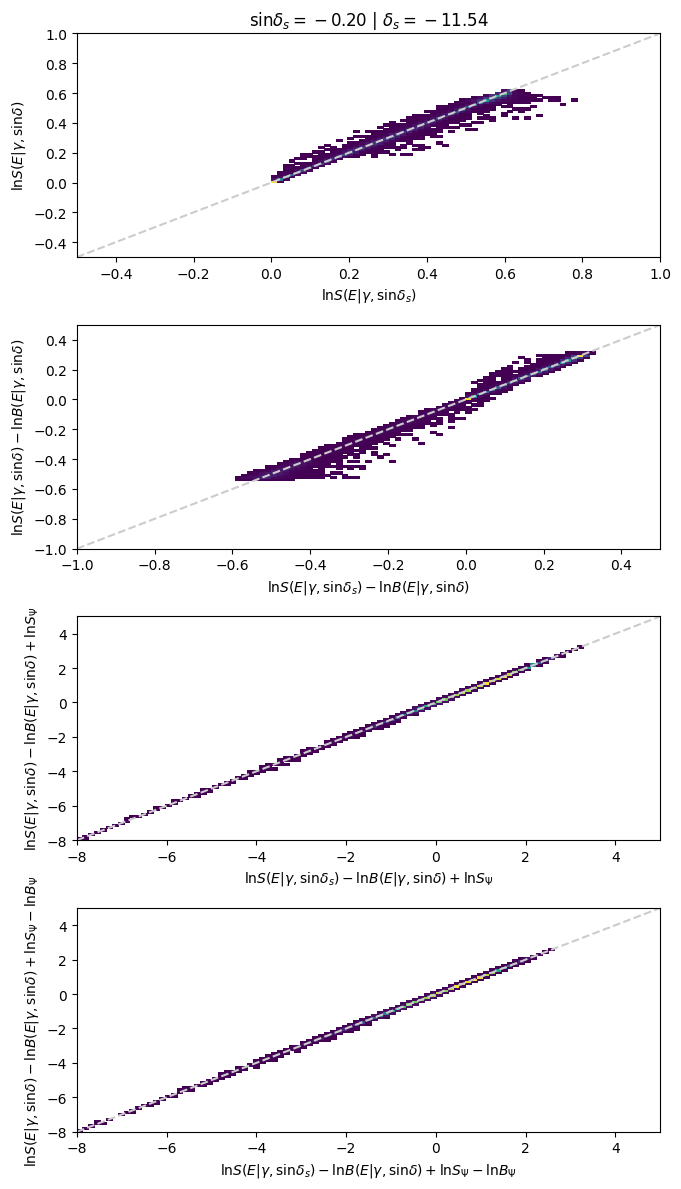

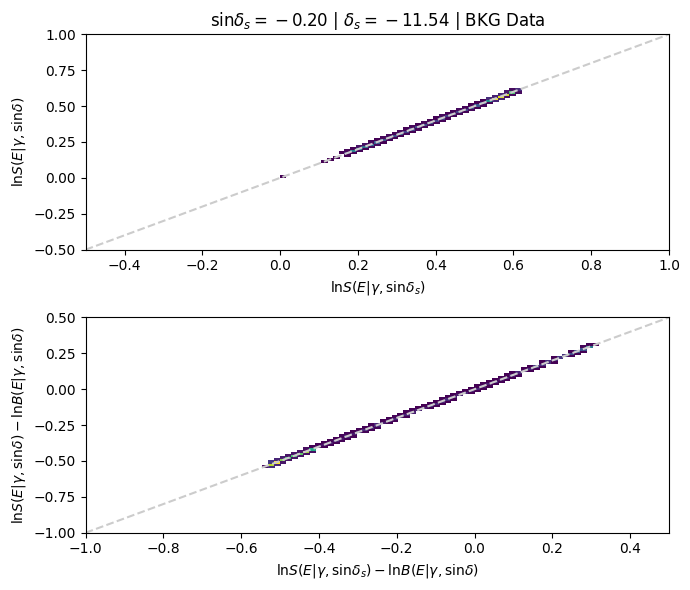

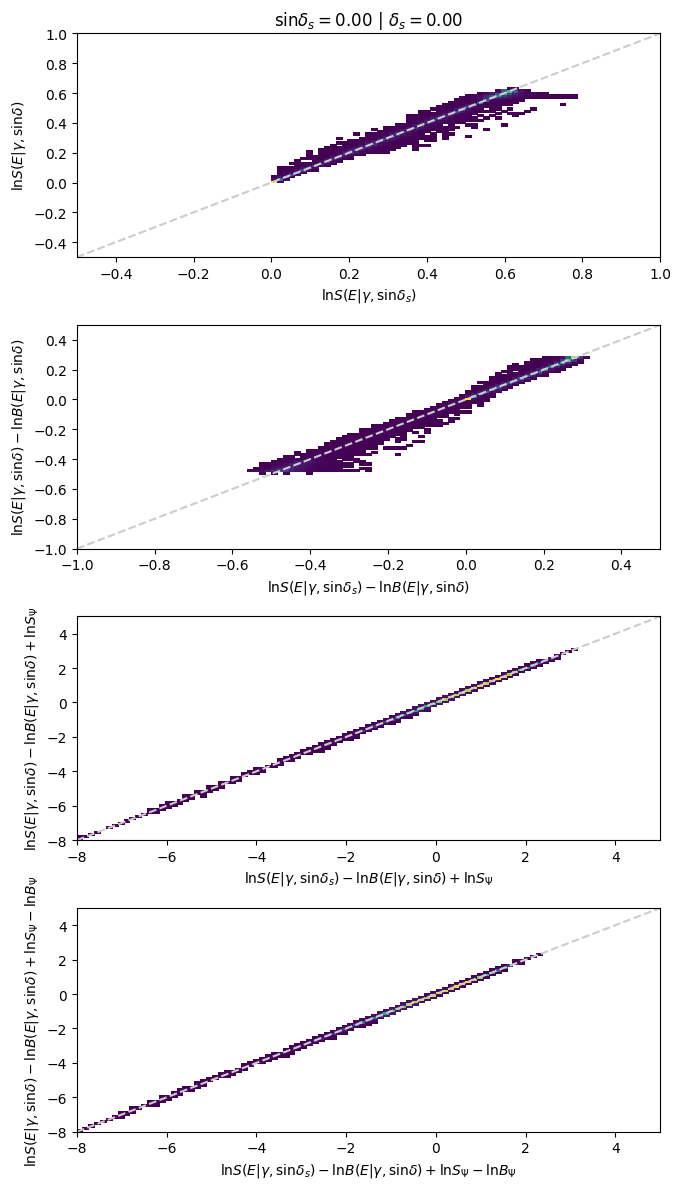

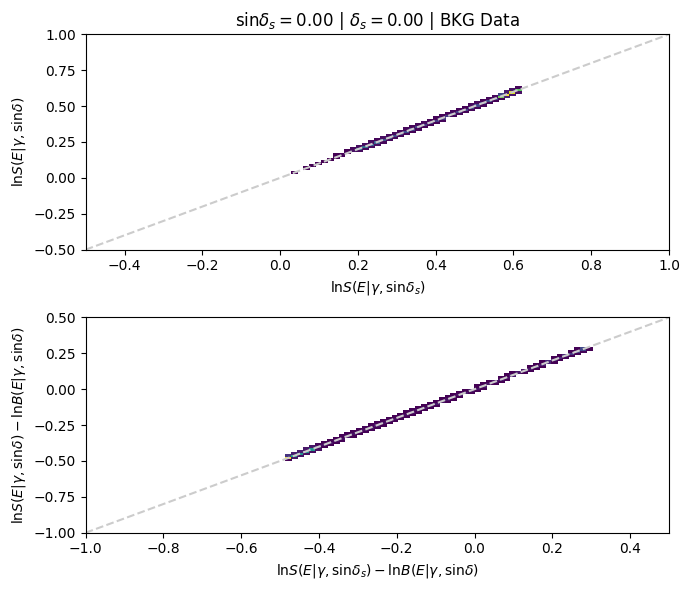

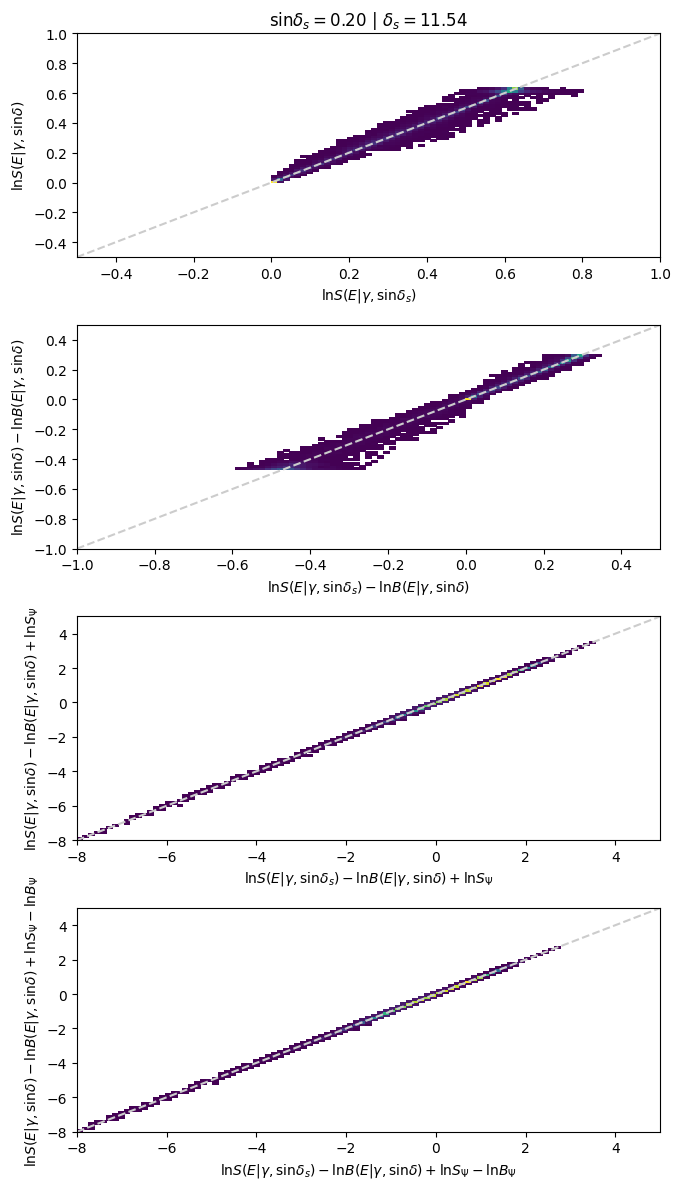

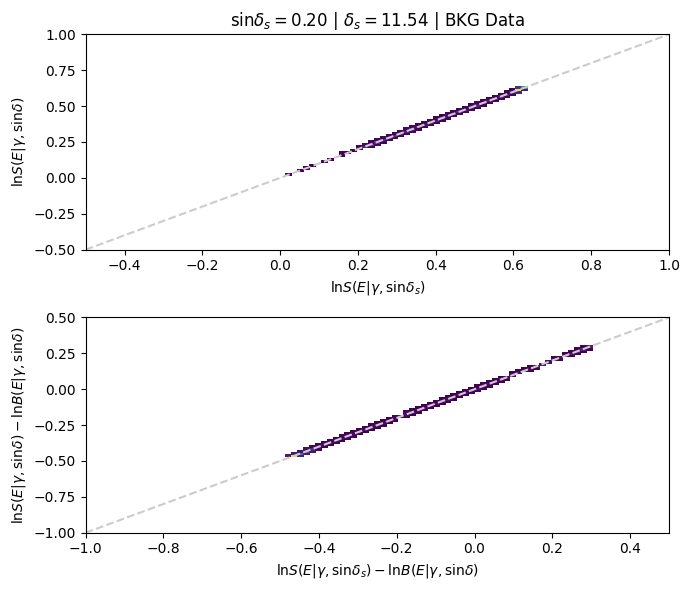

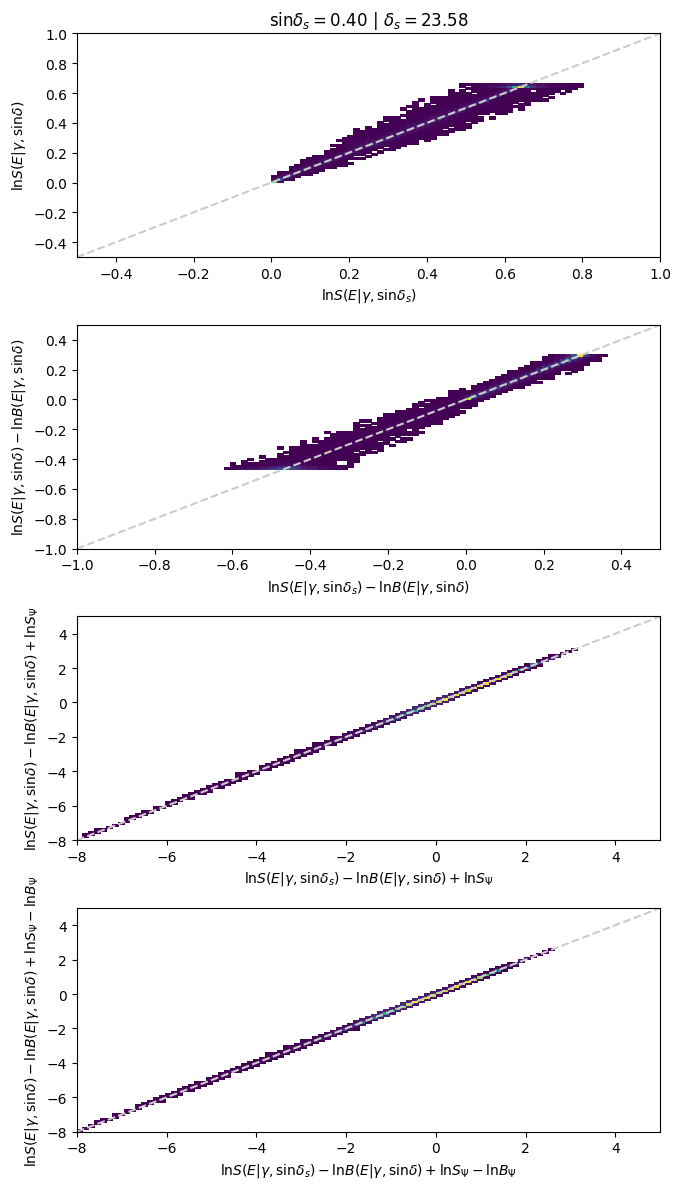

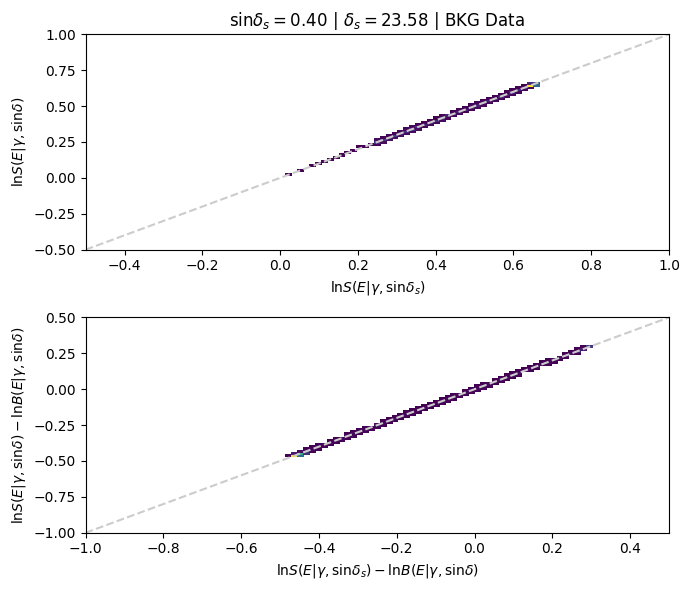

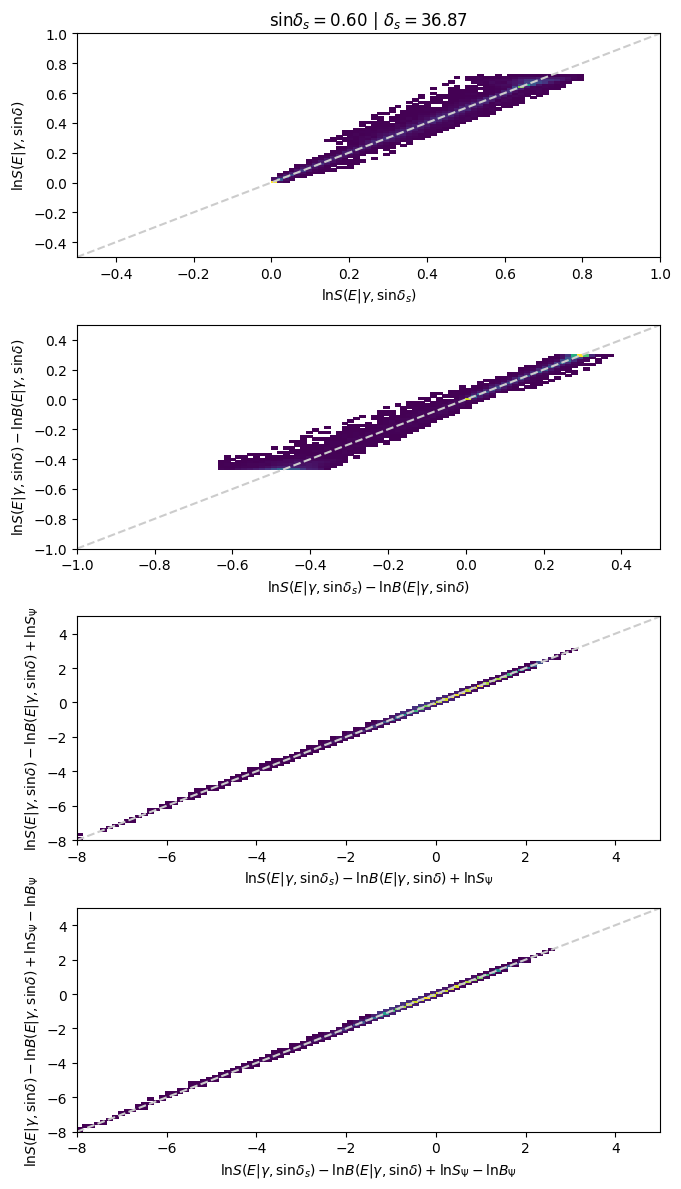

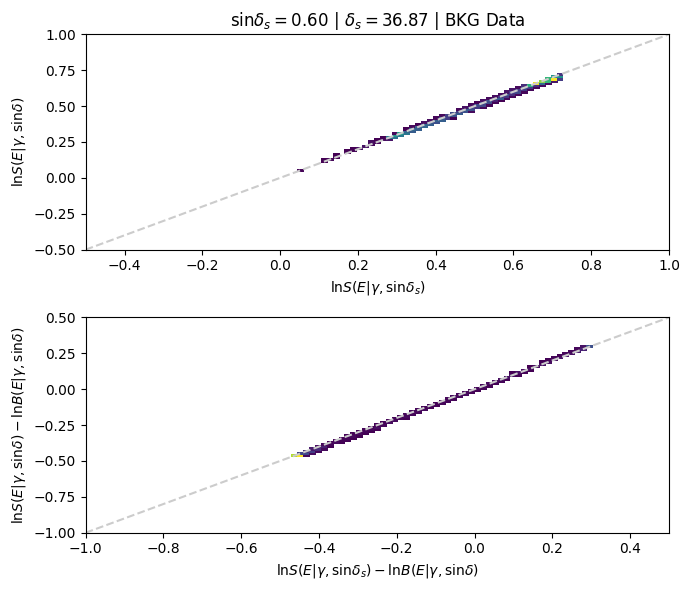

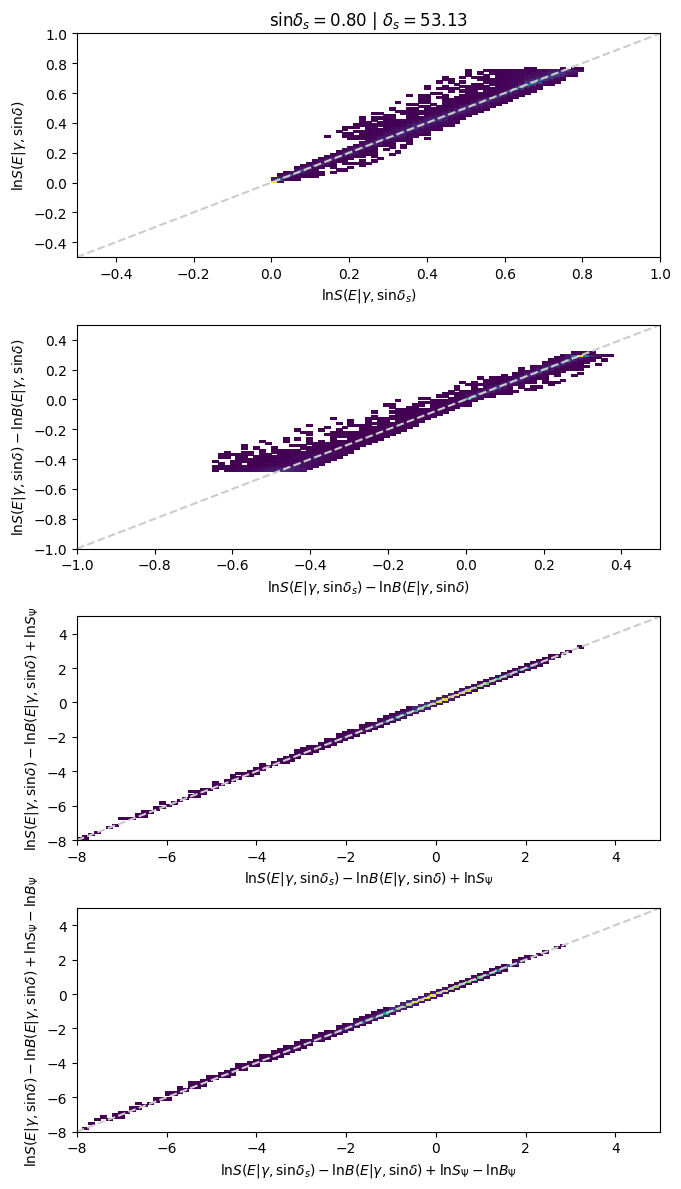

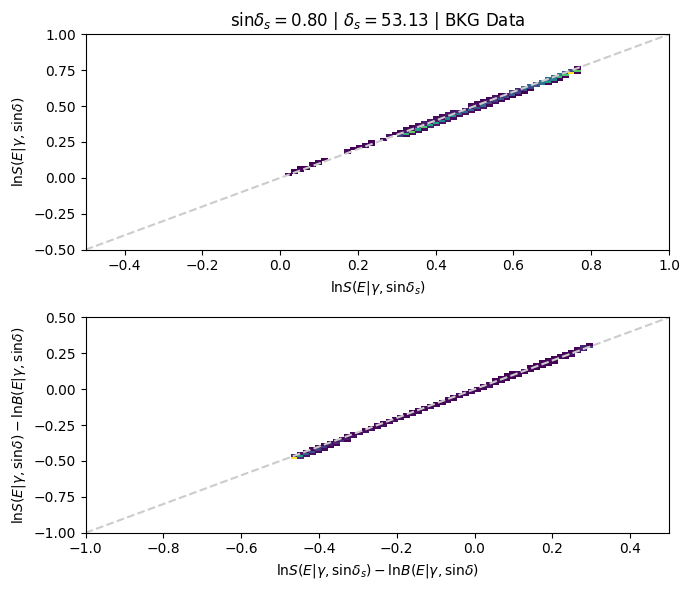

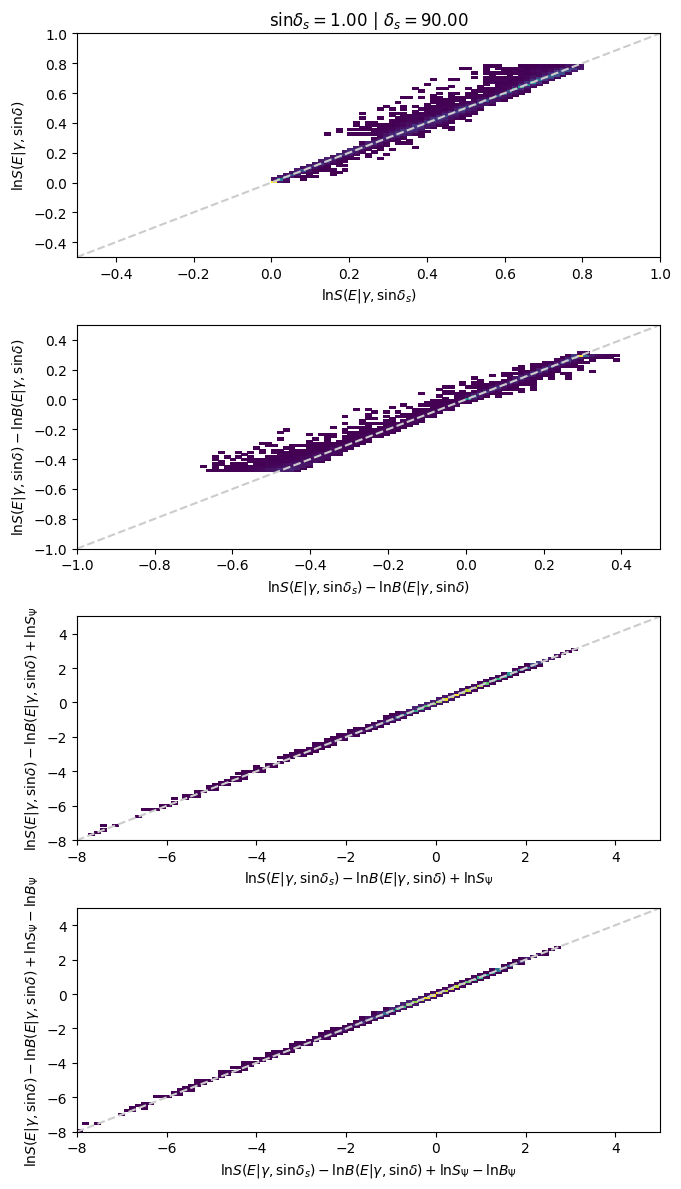

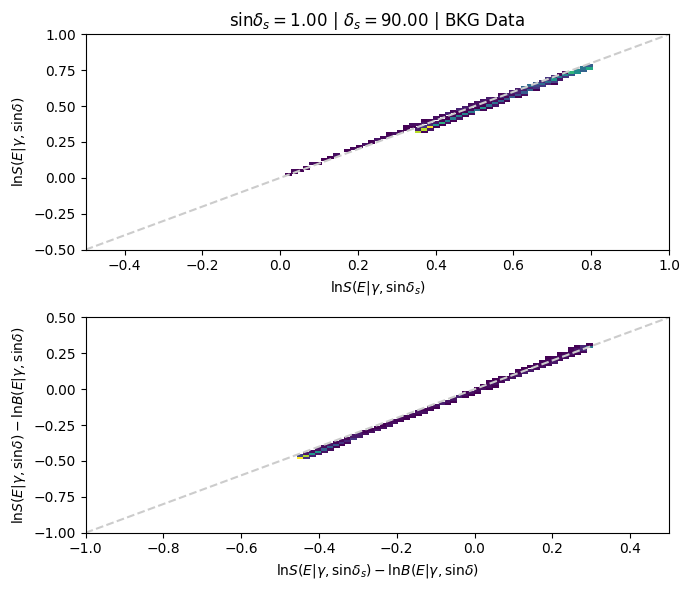

In [275]:
sindec_bandwidth = np.deg2rad(5)

bins = [np.linspace(-0.5, 1, 100)]*2
bins_ratio = [np.linspace(-1, 0.5, 100)]*2
bins_space = [np.linspace(-8, 5, 100)]*2

for sindec in np.linspace(-1.0, 1.0, 11):
    print('Sindec: {:3.3f}'.format(sindec))
    
    mask = np.logical_and(
        a.sig.dec > sindec - 0.5 * sindec_bandwidth,
        a.sig.dec < sindec + 0.5 * sindec_bandwidth,
    )
    mask_bkg = np.logical_and(
        a.bg_data.dec > sindec - 0.5 * sindec_bandwidth,
        a.bg_data.dec < sindec + 0.5 * sindec_bandwidth,
    )
    
    # compute log likelihood over all events
    energy_term = get_log_pdf_s(a.sig.log10energy[mask], true_dec=a.sig.true_dec[mask])
    energy_term_csky = get_log_pdf(a.sig.log10energy[mask], dec=a.sig.dec[mask])
    bkg_term = get_log_pdf_b(a.sig.log10energy[mask], dec=a.sig.dec[mask])
    
    space_term = np.log(ps_pdf.von_mises_in_dPsi_pdf(a.sig.dpsi[mask], sigma=a.sig.sigma[mask]))
    space_term_bkg = get_log_pdf_bkg_sindec(a.sig.sindec[mask])
    
    # llh over background events
    b_energy_term = get_log_pdf_s(a.bg_data.log10energy[mask_bkg], true_dec=a.bg_data.dec[mask_bkg])
    b_energy_term = get_log_pdf_s(a.bg_data.log10energy[mask_bkg], true_dec=np.arcsin(sindec) + np.zeros_like(a.bg_data.dec[mask_bkg]))
    b_energy_term_csky = get_log_pdf(a.bg_data.log10energy[mask_bkg], dec=a.bg_data.dec[mask_bkg])
    b_bkg_term = get_log_pdf_b(a.bg_data.log10energy[mask_bkg], dec=a.bg_data.dec[mask_bkg])
    
    b_space_term_bkg = get_log_pdf_bkg_sindec(a.bg_data.sindec[mask_bkg])
    
    # ---------------------------------------
    # make correlation plot of log PDF values
    # ---------------------------------------
    fig, axes = plt.subplots(4, 1, figsize=(7, 12))
    
    axes[0].hist2d(energy_term, energy_term_csky, bins=bins, cmin=1)
    axes[0].plot(*bins, color='0.8', ls='--')
    axes[0].set_xlabel('$\ln S(E | \gamma, \sin{\delta_s})$')
    axes[0].set_ylabel('$\ln S(E | \gamma, \sin{\delta})$')
    
    axes[1].hist2d(energy_term - bkg_term, energy_term_csky - bkg_term, bins=bins_ratio, cmin=1)
    axes[1].plot(*bins_ratio, color='0.8', ls='--')
    axes[1].set_xlabel('$\ln S(E | \gamma, \sin{\delta_s}) - \ln B(E | \gamma, \sin{\delta})$')
    axes[1].set_ylabel('$\ln S(E | \gamma, \sin{\delta}) - \ln B(E | \gamma, \sin{\delta})$')
    
    axes[2].hist2d(energy_term - bkg_term + space_term, energy_term_csky - bkg_term + space_term, bins=bins_space, cmin=1)
    axes[2].plot(*bins_space, color='0.8', ls='--')
    axes[2].set_xlabel('$\ln S(E | \gamma, \sin{\delta_s}) - \ln B(E | \gamma, \sin{\delta}) + \ln S_\Psi$')
    axes[2].set_ylabel('$\ln S(E | \gamma, \sin{\delta}) - \ln B(E | \gamma, \sin{\delta}) + \ln S_\Psi$')
    
    axes[3].hist2d(energy_term - bkg_term + space_term - space_term_bkg, energy_term_csky - bkg_term + space_term - space_term_bkg, bins=bins_space, cmin=1)
    axes[3].plot(*bins_space, color='0.8', ls='--')
    axes[3].set_xlabel('$\ln S(E | \gamma, \sin{\delta_s}) - \ln B(E | \gamma, \sin{\delta}) + \ln S_\Psi  - \ln B_\Psi$')
    axes[3].set_ylabel('$\ln S(E | \gamma, \sin{\delta}) - \ln B(E | \gamma, \sin{\delta}) + \ln S_\Psi - \ln B_\Psi$')
    
    axes[0].set_title('$\sin\delta_s={:3.2f}$ | $\delta_s={:3.2f}$'.format(sindec, np.rad2deg(np.arcsin(sindec))))
    
    fig.tight_layout()
    fig.savefig(os.path.join(plot_dir, 'pdf_correlations_{:3.2f}.png'.format(sindec)))
    
    # -----------------------------------------------------
    # make correlation plot of log PDF values of BKG events
    # -----------------------------------------------------
    fig, axes = plt.subplots(2, 1, figsize=(7, 6))
    
    axes[0].hist2d(b_energy_term, b_energy_term_csky, bins=bins, cmin=1)
    axes[0].plot(*bins, color='0.8', ls='--')
    axes[0].set_xlabel('$\ln S(E | \gamma, \sin{\delta_s})$')
    axes[0].set_ylabel('$\ln S(E | \gamma, \sin{\delta})$')
    
    axes[1].hist2d(b_energy_term - b_bkg_term, b_energy_term_csky - b_bkg_term, bins=bins_ratio, cmin=1)
    axes[1].plot(*bins_ratio, color='0.8', ls='--')
    axes[1].set_xlabel('$\ln S(E | \gamma, \sin{\delta_s}) - \ln B(E | \gamma, \sin{\delta})$')
    axes[1].set_ylabel('$\ln S(E | \gamma, \sin{\delta}) - \ln B(E | \gamma, \sin{\delta})$')
    
    axes[0].set_title('$\sin\delta_s={:3.2f}$ | $\delta_s={:3.2f}$ | BKG Data'.format(sindec, np.rad2deg(np.arcsin(sindec))))
    
    fig.tight_layout()
    fig.savefig(os.path.join(plot_dir, 'pdf_correlations_bkg_{:3.2f}.png'.format(sindec)))
    # ---------------------------------------
    
    print('E: {:3.3f} | E_csky: {:3.3f} | S/B: {:3.3f} | S/B_csky: {:3.3f} | True/csky: {:3.3f}% {:3.3f}% {:3.3f}% {:3.3f}%'.format(
        np.sum(energy_term), np.sum(energy_term_csky), 
        np.sum(energy_term - bkg_term), np.sum(energy_term_csky - bkg_term), 
        np.sum(energy_term) / np.sum(energy_term_csky) * 100, 
        np.sum(energy_term - bkg_term) / np.sum(energy_term_csky - bkg_term) * 100, 
        np.sum(energy_term - bkg_term + space_term) / np.sum(energy_term_csky - bkg_term + space_term) * 100, 
        np.sum(energy_term - bkg_term + space_term - space_term_bkg) / np.sum(energy_term_csky - bkg_term + space_term - space_term_bkg) * 100, 
    ))
    
    print('[BKG] E: {:3.3f} | E_csky: {:3.3f} | S/B: {:3.3f} | S/B_csky: {:3.3f} | True/csky: {:3.3f}% '.format(
        np.sum(b_energy_term), np.sum(b_energy_term_csky), 
        np.sum(b_energy_term - b_bkg_term), np.sum(b_energy_term_csky - b_bkg_term), 
        np.sum(b_energy_term) / np.sum(b_energy_term_csky) * 100, 
        np.sum(b_energy_term - b_bkg_term) / np.sum(b_energy_term_csky - b_bkg_term) * 100, 
    ))
    
    

In [277]:
from scipy import stats
stats.chi2.fit()

AttributeError: module 'scipy.stats' has no attribute 'ch'